## Harpegnathos saltator snRNAseq Analysis

antman environment

In [1]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Bio.SeqIO as SeqIO
import sys
from tqdm import tqdm
import re
from pygenomeviz import GenomeViz
import scipy.stats as stats
from matplotlib.lines import Line2D
import seaborn as sns
from scipy.stats import ttest_rel
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
import math
sys.path.append('../')
from transcriptomics import *
from plotting import * 
white_plotting()

/Users/giacomo.glotzer/miniconda3/envs/antman/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/giacomo.glotzer/miniconda3/envs/antman/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/giacomo.glotzer/miniconda3/envs/antman/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/giacomo.glotzer/miniconda3/envs/antman/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/Users/giacomo.glotzer/miniconda3/envs/antman/lib/python3.12/s

Initializing transcriptomics package
Initializing plotting package


In [2]:
sc.set_figure_params(dpi=100, color_map="viridis_r")
sc.settings.verbosity = 0 
sc.logging.print_header()

scanpy==1.10.1 anndata==0.11.4 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.1 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [3]:
# set pd max columns to 100 and max rows to 10 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10)

## Genome

In [4]:
# Load genome
genome_fasta_path = '../raw-data/Hsalt/genome/GCF_003227715.2_Hsal_v8.6_genomic.fna'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

In [5]:
# Get number of scaffolds 
scaffolds = list(genome_seq.keys())
print(f'Number of scaffolds: {len(scaffolds)}')

# Make a dictionary of scaffold lengths
scaffold_lengths = {scaffold:len(genome_seq[scaffold].seq) for scaffold in scaffolds}
scaffold_lengths = pd.DataFrame.from_dict(scaffold_lengths, orient='index', columns=['length'])
scaffold_lengths = scaffold_lengths.sort_values(by='length', ascending=False)
scaffold_lengths

Number of scaffolds: 850


length
NW_020230721.1  3353128
NW_020230183.1  3092591
NW_020230404.1  3063442
NW_020230531.1  2893175
NW_020230039.1  2819439
...                 ...
NW_020230259.1     8806
NW_020230430.1     8538
NW_020230613.1     7672
NW_020230167.1     6468
NW_020230326.1     5668

[850 rows x 1 columns]

## Custom OR Transcriptome
- Gene uses `gene_id` and transcript uses `transcript_id`
- Only run this once

In [6]:
genome_fasta_path = '../raw-data/Hsalt/genome/GCF_003227715.2_Hsal_v8.6_genomic.fna'
transcriptome_path = "../raw-data/Hsalt/transcriptome/GSE235819_HSAL60.gtf"
object_name = "../raw-data/Hsalt/transcriptome/hsaltator_transcriptome"
update_transcriptome_object(genome_fasta_path, transcriptome_path, object_name, other_fields=['gene_biotype', 'transcript_biotype']) 

Found 14407 unique genes.


100%|██████████| 14407/14407 [00:31<00:00, 455.08it/s] 


Transcriptome(genes=14407)
Transcriptome object has been updated and saved to ../raw-data/Hsalt/transcriptome/hsaltator_transcriptome.pkl


In [7]:
object_name = "../raw-data/Hsalt/transcriptome/hsaltator_transcriptome"
tr = load_transcriptome_object(object_name)

In [8]:
check_exons_contain_all_features(tr)

In [9]:
all_genes = [tr.get_gene(gene) for gene in tr.genes.keys() if len(tr.get_gene(gene).transcripts) > 0]
all_lncRNAs = [gene for gene in all_genes if gene.transcript_biotype == 'lnc_RNA']
len(all_lncRNAs), len(all_genes)

(0, 14407)

## NCBI Transcriptome 
- Includes lncRNAs 

In [10]:
genome_fasta_path = '../raw-data/Hsalt/genome/GCF_003227715.2_Hsal_v8.6_genomic.fna'
transcriptome_path = "../raw-data/Hsalt/transcriptome/Hsal_v86_ncbi_transcriptome.gtf"
object_name = "../raw-data/Hsalt/transcriptome/hsaltator_transcriptome_ncbi"
update_transcriptome_object(genome_fasta_path, transcriptome_path, object_name, other_fields=['gene_biotype', 'transcript_biotype']) 

Found 14328 unique genes.


100%|██████████| 14328/14328 [00:27<00:00, 519.77it/s] 


Transcriptome(genes=14328)
Transcriptome object has been updated and saved to ../raw-data/Hsalt/transcriptome/hsaltator_transcriptome_ncbi.pkl


In [11]:
object_name = "../raw-data/Hsalt/transcriptome/hsaltator_transcriptome_ncbi"
tr_ncbi = load_transcriptome_object(object_name)

In [12]:
check_exons_contain_all_features(tr_ncbi)

In [13]:
all_genes = [tr_ncbi.get_gene(gene) for gene in tr_ncbi.genes.keys() if len(tr_ncbi.get_gene(gene).transcripts) > 0]
all_lncRNAs = [gene for gene in all_genes if gene.transcript_biotype == 'lnc_RNA']
len(all_lncRNAs), len(all_genes)

(1029, 14020)

## OR DB

In [14]:
all_genes = [tr.get_gene(gene) for gene in tr.genes.keys() if len(tr.get_gene(gene).transcripts) > 0]

In [15]:
# Get a list of all genes 
all_genes = list(tr.genes.keys())
all_ORs = [gene for gene in all_genes if "HsOr" in gene]
print(f"Identified {len(all_ORs)} OR genes")

Identified 377 OR genes


In [16]:
# Look for any ORs that don't contain a number 
ORs_no_number = [gene for gene in all_ORs if not re.search(r'\d', gene)]
ORs_no_number

['HsOrco']

In [17]:
# Get tuning ORs 
ORXs = [gene for gene in all_ORs if re.search(r'\d', gene)]

In [18]:
# Look for ORX containing "_" 
ORXs_with_underscore = [gene for gene in ORXs if "_" in gene]
print(f"Identified {len(ORXs_with_underscore)} ORX genes with underscore: {ORXs_with_underscore}")
# Remove ORXs with underscore
ORXs = [gene for gene in ORXs if gene not in ORXs_with_underscore]
print("removed ORXs with underscore")

Identified 1 ORX genes with underscore: ['HsOr126_127']
removed ORXs with underscore


In [19]:
# Creat DF containing gene name and number
all_ORX_float = [float(gene.split("HsOr")[1]) for gene in ORXs]
ORXs = pd.DataFrame({"gene_name": ORXs, "gene_number": all_ORX_float})

In [20]:
# Save the scaffold, start, end, strand, n_exons, and nine_exon columns
for i, row in ORXs.iterrows():
    gene = row["gene_name"]
    gene_obj = tr.get_gene(gene)
    if len(gene_obj.transcripts) > 0: 
        transcript = gene_obj.get_transcript_longest_cds() 
        scaffold = transcript.chromosome 
        start, end = transcript.get_bounds() 
        strand = transcript.strand
        n_exons = len(transcript.exons)
        ORXs.loc[i, "scaffold"] = scaffold
        ORXs.loc[i, "start"] = start
        ORXs.loc[i, "end"] = end
        ORXs.loc[i, "strand"] = strand
        ORXs.loc[i, "n_exons"] = n_exons
        ORXs.loc[i, "nine_exon"] = n_exons == 9
    else:
        print(f"ORX {gene} has no transcripts")
ORXs

gene_name  gene_number        scaffold      start        end strand  \
0      HsOr10         10.0  NW_020229890.1  1306224.0  1308880.0      -   
1     HsOr100        100.0  NW_020230518.1   134832.0   138001.0      +   
2     HsOr101        101.0  NW_020230518.1   125705.0   129088.0      +   
3     HsOr102        102.0  NW_020230518.1   118877.0   123689.0      +   
4     HsOr103        103.0  NW_020230518.1   115171.0   117559.0      +   
..        ...          ...             ...        ...        ...    ...   
370    HsOr95         95.0  NW_020230518.1   162967.0   165348.0      +   
371    HsOr96         96.0  NW_020230518.1   155815.0   159847.0      +   
372    HsOr97         97.0  NW_020230518.1   152000.0   155038.0      +   
373    HsOr98         98.0  NW_020230518.1   145405.0   149507.0      +   
374    HsOr99         99.0  NW_020230518.1   139759.0   144287.0      +   

     n_exons nine_exon  
0        5.0     False  
1        7.0     False  
2        6.0     False  
3        5.0     False  
4        6.0     False  
..       ...       ...  
370      7.0     False  
371      7.0     False  
372      7.0     False  
373      7.0     False  
374      7.0     False  

[375 rows x 8 columns]

In [21]:
# Sort by scaffold and start 
ORXs_sorted = ORXs.sort_values(["scaffold", "start"]).reset_index(drop=True)
ORXs_sorted['rank'] = ORXs_sorted.index 
ORXs_sorted

gene_name  gene_number        scaffold      start        end strand  \
0      HsOr44         44.0  NW_020229890.1  1212870.0  1216852.0      -   
1      HsOr45         45.0  NW_020229890.1  1218489.0  1221077.0      -   
2      HsOr46         46.0  NW_020229890.1  1221616.0  1225747.0      -   
3      HsOr47         47.0  NW_020229890.1  1227302.0  1229819.0      -   
4      HsOr48         48.0  NW_020229890.1  1233006.0  1235746.0      -   
..        ...          ...             ...        ...        ...    ...   
370   HsOr207        207.0  NW_020230682.1   876755.0   880643.0      +   
371   HsOr206        206.0  NW_020230682.1   881680.0   884301.0      +   
372   HsOr205        205.0  NW_020230682.1   892748.0   897334.0      +   
373   HsOr204        204.0  NW_020230682.1   900916.0   905034.0      +   
374   HsOr203        203.0  NW_020230682.1   906519.0   908696.0      +   

     n_exons nine_exon  rank  
0        7.0     False     0  
1        5.0     False     1  
2        7.0     False     2  
3        5.0     False     3  
4        6.0     False     4  
..       ...       ...   ...  
370      5.0     False   370  
371      4.0     False   371  
372      4.0     False   372  
373      5.0     False   373  
374      7.0     False   374  

[375 rows x 9 columns]

In [22]:
# Count how many ORs are 9E 
n_nine_exon_ORs = ORXs["nine_exon"].sum()
print(f"Identified {n_nine_exon_ORs} 9-exon ORs")

Identified 101 9-exon ORs


## Annotate Tandem Arrays

In [23]:
ta_db_path = "../raw-data/Hsalt/supplement/adk9000_Table_S3.xlsx"
ta_db = pd.read_excel(ta_db_path)
ta_db.head(3)

locus        scaffold      coordinates                    Ors_within_locus  \
0      1  NW_020229890.1  1212870-1424437         HsOr44-HsOr59, HsOr2-HsOr43   
1      2  NW_020230427.1    620807-959418    HsOr325-HsOr306, HsOr326-HsOr351   
2      3  NW_020229910.1    510020-673088  HsOr170-HsOr167, HsOr131.1-HsOr166   

   number_of_Ors_within_locus  \
0                          58   
1                          44   
2                          39   

                             Or_expression_in_mutant  \
0  HsOr49-HsOr53 in support cells, HsOr58 in glia...   
1     all genes in support cells, possibly also glia   
2                  HsOr160, HsOr161 in support cells   

  neighboring_non-Or(s)_with_similar_non-neuronal_expression  \
0                    LOC105188517.LOC112589549, G918           
1  LOC105182725, LOC105182715, LOC105182711, LOC1...           
2                                              G1637           

  is_any_such_non-Or_directly_bordering_the_Or_locus  
0                                                 NO  
1                                                YES  
2                                                 NO

In [24]:
# Assert that every scaffold in ta_db.scaffold is in the genome
assert ta_db.scaffold.isin(scaffold_lengths.index).all()

In [25]:
# Assert that every scaffold in ORXs_sorted.scaffold is in ta_db.scaffold
assert ORXs_sorted.scaffold.isin(ta_db.scaffold).all()

In [26]:
# Make a df called or_db containing a list of ORs and their respective TAs 
or_db = []
for i, ta_row in ta_db.iterrows():
    ors = ta_row["Ors_within_locus"] 
    ta = ta_row["locus"]
    ta_scaffold = ta_row["scaffold"]
    ta_coords = ta_row["coordinates"]
    ta_size = ta_row["number_of_Ors_within_locus"]
    # Find ORs within the locus 
    ta_start = int(ta_coords.split("-")[0]) - 100
    ta_end = int(ta_coords.split("-")[1]) + 100
    for j, orx_row in ORXs_sorted.iterrows():
        orx = orx_row["gene_name"]
        orx_scaffold = orx_row["scaffold"]
        orx_start = orx_row["start"]
        orx_end = orx_row["end"]
        if orx_scaffold == ta_scaffold and orx_start >= ta_start and orx_end <= ta_end:
            orx_row["tandem_array"] = ta
            orx_row["ta_size"] = ta_size
            or_db.append(orx_row)

or_db = pd.DataFrame(or_db)
# Sort by TA and rank 
or_db = or_db.sort_values(["scaffold", "start"]).reset_index(drop=True)
or_db

gene_name  gene_number        scaffold      start        end strand  \
0      HsOr44         44.0  NW_020229890.1  1212870.0  1216852.0      -   
1      HsOr45         45.0  NW_020229890.1  1218489.0  1221077.0      -   
2      HsOr46         46.0  NW_020229890.1  1221616.0  1225747.0      -   
3      HsOr47         47.0  NW_020229890.1  1227302.0  1229819.0      -   
4      HsOr48         48.0  NW_020229890.1  1233006.0  1235746.0      -   
..        ...          ...             ...        ...        ...    ...   
368   HsOr207        207.0  NW_020230682.1   876755.0   880643.0      +   
369   HsOr206        206.0  NW_020230682.1   881680.0   884301.0      +   
370   HsOr205        205.0  NW_020230682.1   892748.0   897334.0      +   
371   HsOr204        204.0  NW_020230682.1   900916.0   905034.0      +   
372   HsOr203        203.0  NW_020230682.1   906519.0   908696.0      +   

     n_exons  nine_exon  rank  tandem_array  ta_size  
0        7.0      False     0             1       58  
1        5.0      False     1             1       58  
2        7.0      False     2             1       58  
3        5.0      False     3             1       58  
4        6.0      False     4             1       58  
..       ...        ...   ...           ...      ...  
368      5.0      False   370            16        6  
369      4.0      False   371            16        6  
370      4.0      False   372            16        6  
371      5.0      False   373            16        6  
372      7.0      False   374            16        6  

[373 rows x 11 columns]

In [27]:
# Check that the TA_size column reflects the number of ORs in each TA
for ta in or_db.tandem_array.unique():
    ta_size = or_db.loc[or_db.tandem_array == ta, "ta_size"].values[0]
    ors_in_ta = or_db.loc[or_db.tandem_array == ta].shape[0]
    if ta_size != ors_in_ta:
        print(f"TA {ta} has {ta_size} ORs in or_db but {ors_in_ta} ORs in the TA DB")

TA 9 has 13 ORs in or_db but 12 ORs in the TA DB
TA 5 has 30 ORs in or_db but 29 ORs in the TA DB


In [28]:
# Save the ta_index: the index of each OR within its TA
or_db = or_db.sort_values(["scaffold", "start"]).reset_index(drop=True)
for ta in or_db.tandem_array.unique():
    ta_size = or_db.loc[or_db.tandem_array == ta].shape[0]
    for i in range(ta_size):
        or_db.loc[or_db.tandem_array == ta, "ta_index"] = range(ta_size)

# Save the predominant strand of each TA 
for ta in or_db.tandem_array.unique():
    ta_strand = or_db.loc[or_db.tandem_array == ta, "strand"].value_counts().index[0]
    or_db.loc[or_db.tandem_array == ta, "ta_strand"] = ta_strand 


or_db

gene_name  gene_number        scaffold      start        end strand  \
0      HsOr44         44.0  NW_020229890.1  1212870.0  1216852.0      -   
1      HsOr45         45.0  NW_020229890.1  1218489.0  1221077.0      -   
2      HsOr46         46.0  NW_020229890.1  1221616.0  1225747.0      -   
3      HsOr47         47.0  NW_020229890.1  1227302.0  1229819.0      -   
4      HsOr48         48.0  NW_020229890.1  1233006.0  1235746.0      -   
..        ...          ...             ...        ...        ...    ...   
368   HsOr207        207.0  NW_020230682.1   876755.0   880643.0      +   
369   HsOr206        206.0  NW_020230682.1   881680.0   884301.0      +   
370   HsOr205        205.0  NW_020230682.1   892748.0   897334.0      +   
371   HsOr204        204.0  NW_020230682.1   900916.0   905034.0      +   
372   HsOr203        203.0  NW_020230682.1   906519.0   908696.0      +   

     n_exons  nine_exon  rank  tandem_array  ta_size  ta_index ta_strand  
0        7.0      False     0             1       58       0.0         -  
1        5.0      False     1             1       58       1.0         -  
2        7.0      False     2             1       58       2.0         -  
3        5.0      False     3             1       58       3.0         -  
4        6.0      False     4             1       58       4.0         -  
..       ...        ...   ...           ...      ...       ...       ...  
368      5.0      False   370            16        6       1.0         +  
369      4.0      False   371            16        6       2.0         +  
370      4.0      False   372            16        6       3.0         +  
371      5.0      False   373            16        6       4.0         +  
372      7.0      False   374            16        6       5.0         +  

[373 rows x 13 columns]

In [29]:
# How many unique TAs? 
n_unique_tas = or_db.tandem_array.nunique()
print(f"Identified {n_unique_tas} unique TAs")

Identified 43 unique TAs


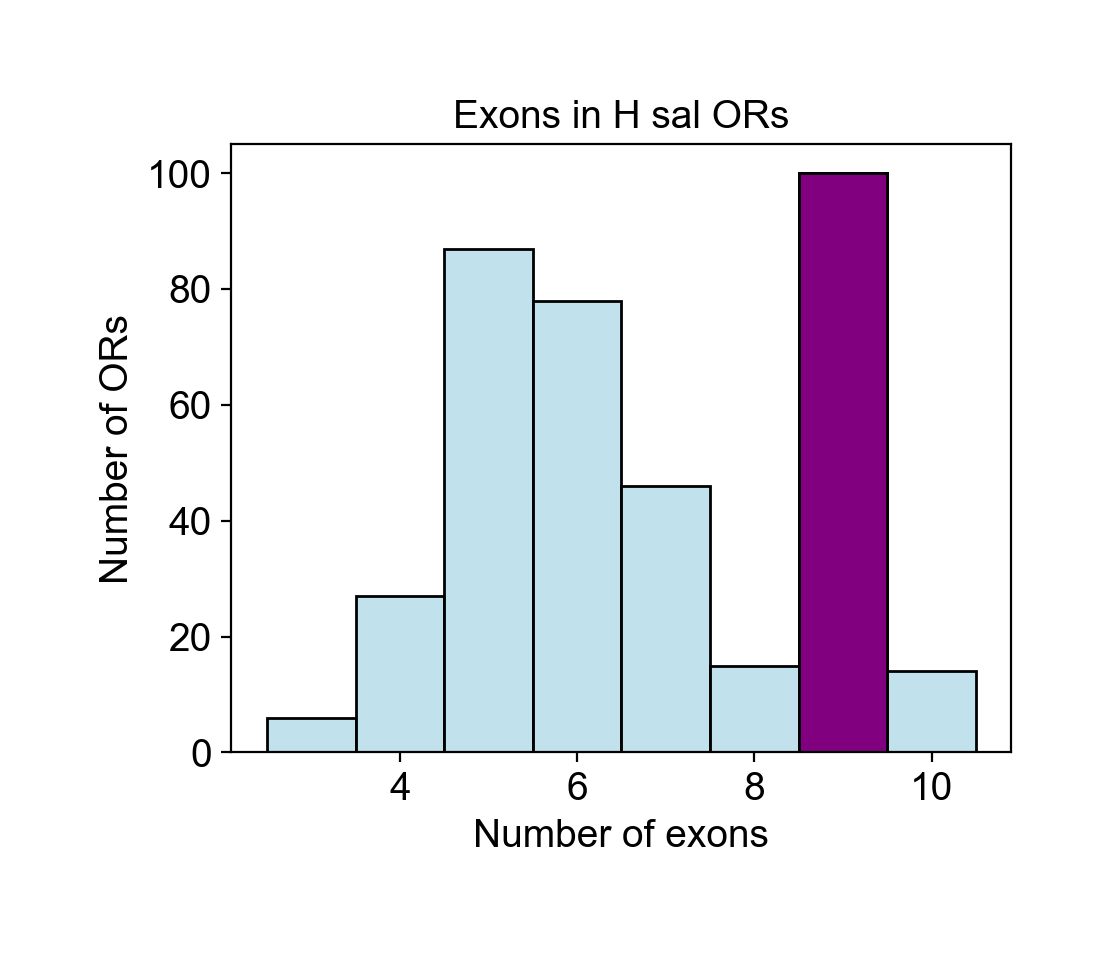

In [30]:
# Plot the distribution of exon numbers in ORs
white_plotting()
plt.figure(figsize=(5, 4))
sns.histplot(or_db["n_exons"], color="lightblue", discrete=True)
plt.bar(9, or_db["n_exons"].value_counts()[9], color="purple", edgecolor="black", width=1)
plt.xlabel("Number of exons")
plt.ylabel("Number of ORs")
plt.title("Exons in H sal ORs")
plt.show()

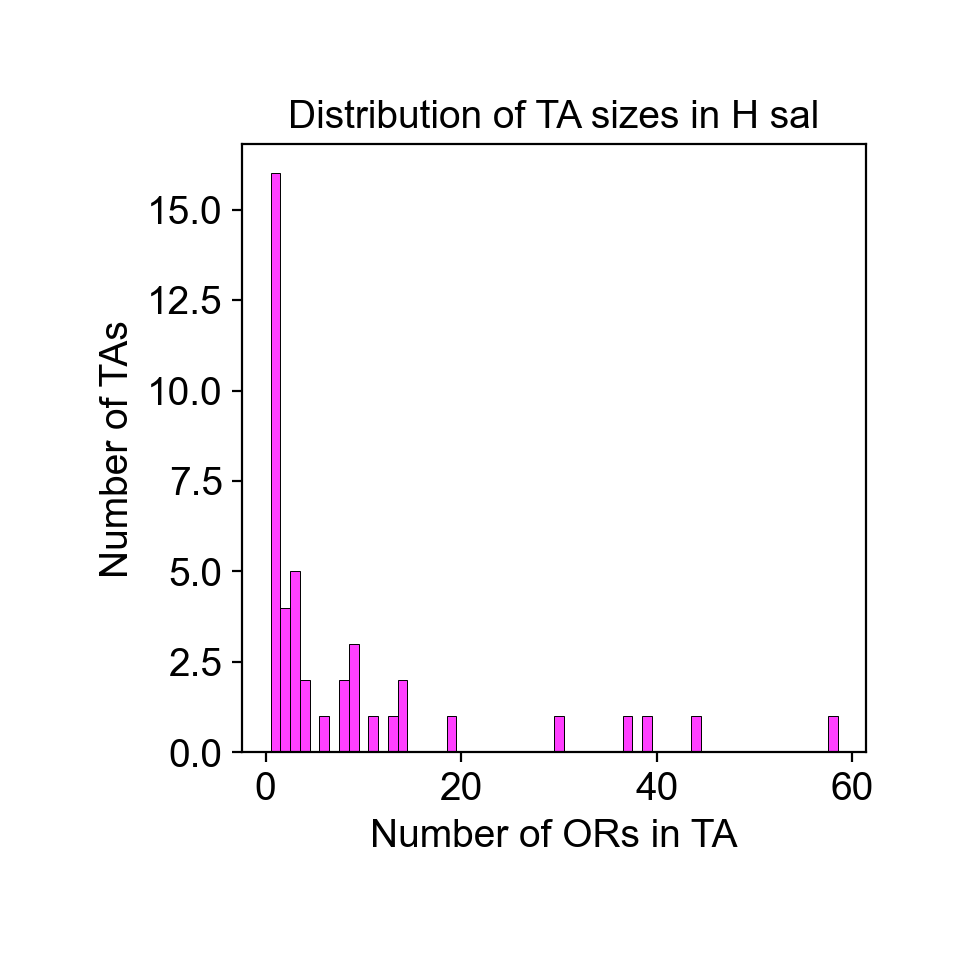

In [31]:
# Plot the distribution of TA sizes
first_rows = or_db.groupby('tandem_array').first()
white_plotting()
plt.figure(figsize=(4, 4))
sns.histplot(first_rows.ta_size, color="magenta", discrete=True)
plt.xlabel("Number of ORs in TA")
plt.ylabel("Number of TAs")
plt.title("Distribution of TA sizes in H sal")
plt.show()

## Load Data

In [32]:
base_dir = "../raw-data/Hsalt/snRNAseq/"
samples = ["WT1", "WT2", "WT3"]
adatas = {}
for sample in samples:
    input_dir = base_dir + sample 
    adata = sc.read_10x_mtx(input_dir, var_names='gene_symbols', cache=True)  
    adata.var_names_make_unique()
    adata.obs["sample"] = sample
    adatas[sample] = adata

In [33]:
# Concatenate all samples into one AnnData object
adata = adatas["WT1"].concatenate(adatas["WT2"], adatas["WT3"], batch_key="sample")

In [34]:
print(f"Number of cells: {adata.n_obs}, number of genes: {adata.n_vars}")

Number of cells: 17802, number of genes: 14407


In [35]:
# QC 
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 17802 × 14407
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [36]:
# Filter genes and cells
sc.pp.filter_genes(adata, min_cells=2)  # Remove genes expressed in fewer than 10 cells
print(f"Number of cells: {adata.n_obs}, number of genes: {adata.n_vars} after filtering genes")

sc.pp.filter_cells(adata, min_genes=100)  # Remove cells with fewer than 200 genes expressed
print(f"Number of cells: {adata.n_obs}, number of genes: {adata.n_vars} after filtering cells")

Number of cells: 17802, number of genes: 13377 after filtering genes
Number of cells: 17802, number of genes: 13377 after filtering cells


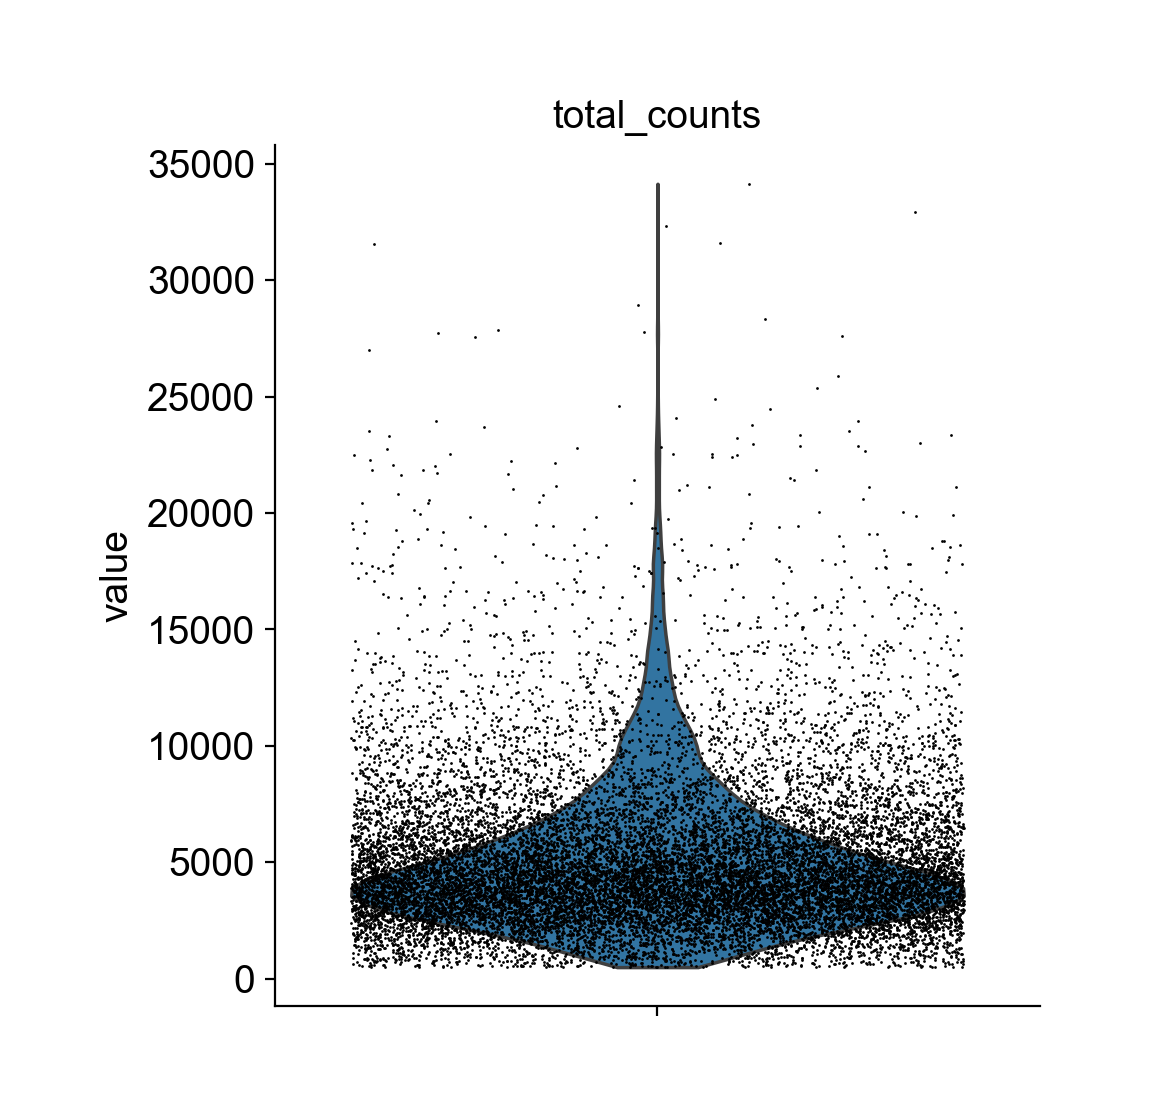

In [37]:
# Make histograms of `nCount_RNA` and `nFeature_RNA` for both datasets (both in obs)
white_plotting()    
sc.pl.violin(adata, ['total_counts'], jitter=0.4, multi_panel=True)

In [38]:
# Normalize total counts per cell
sc.pp.normalize_total(adata, target_sum=1e4) # Obir value 
print("Normalizing total counts per cell")

# Log-transform the data
sc.pp.log1p(adata)  
print("Log-transforming data")

Normalizing total counts per cell
Log-transforming data


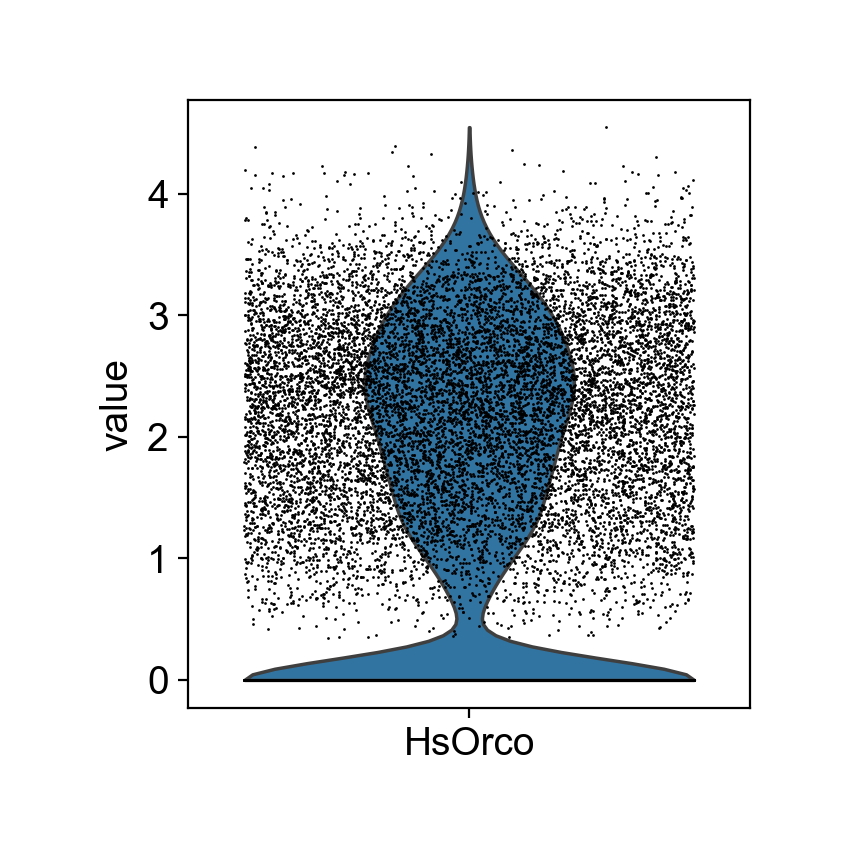

Number of cells with zero Orco expression: 5304


In [39]:
# Plot Orco expression as a violin 
white_plotting()
sc.pl.violin(adata, ['HsOrco'], jitter=0.4)
# Print how many cells have zero Orco 
print(f"Number of cells with zero Orco expression: {sum(adata[:, 'HsOrco'].X.toarray().flatten() == 0)}")

In [40]:
# PCA 
sc.pp.pca(adata) 
print("Performed PCA")

Performed PCA


In [41]:
# Scanorama integration
sce.pp.scanorama_integrate(adata, key="sample")
print("Integrated data with Scanorama, results stored in adata.obsm['X_scanorama']")

[[0.         0.90274983 0.66130114]
 [0.         0.         0.95105616]
 [0.         0.         0.        ]]
Processing datasets 1 <=> 2
Processing datasets 0 <=> 1
Processing datasets 0 <=> 2
Integrated data with Scanorama, results stored in adata.obsm['X_scanorama']


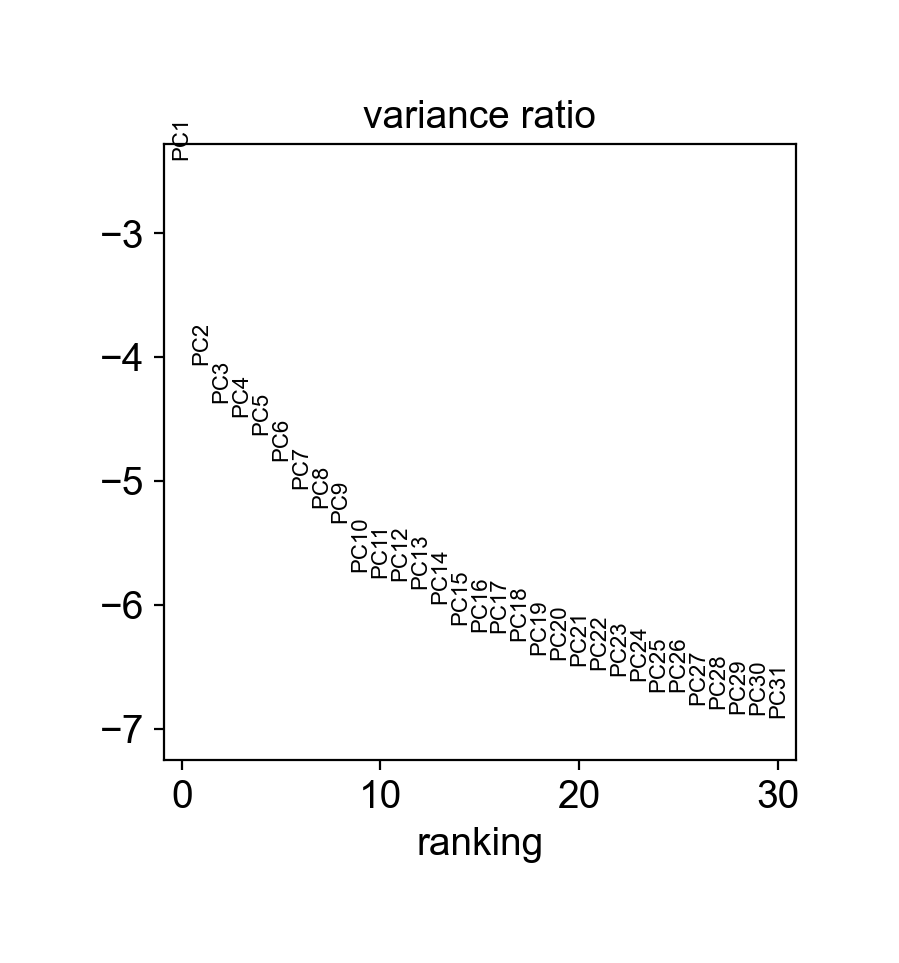

In [42]:
# Plot variance vs PCs 
white_plotting()
sc.pl.pca_variance_ratio(adata, log=True)

In [43]:
sc.pp.highly_variable_genes(adata, min_mean=0.001, max_mean=5, min_disp=0.5)

In [44]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30, use_rep="X_scanorama")
print("Computed neighborhood graph")

Computed neighborhood graph


In [45]:
sc.tl.umap(adata) 
print("Computed UMAP")

Computed UMAP


In [46]:
sc.tl.leiden(adata, resolution=0.5) 
print("Performed Leiden clustering")

Performed Leiden clustering


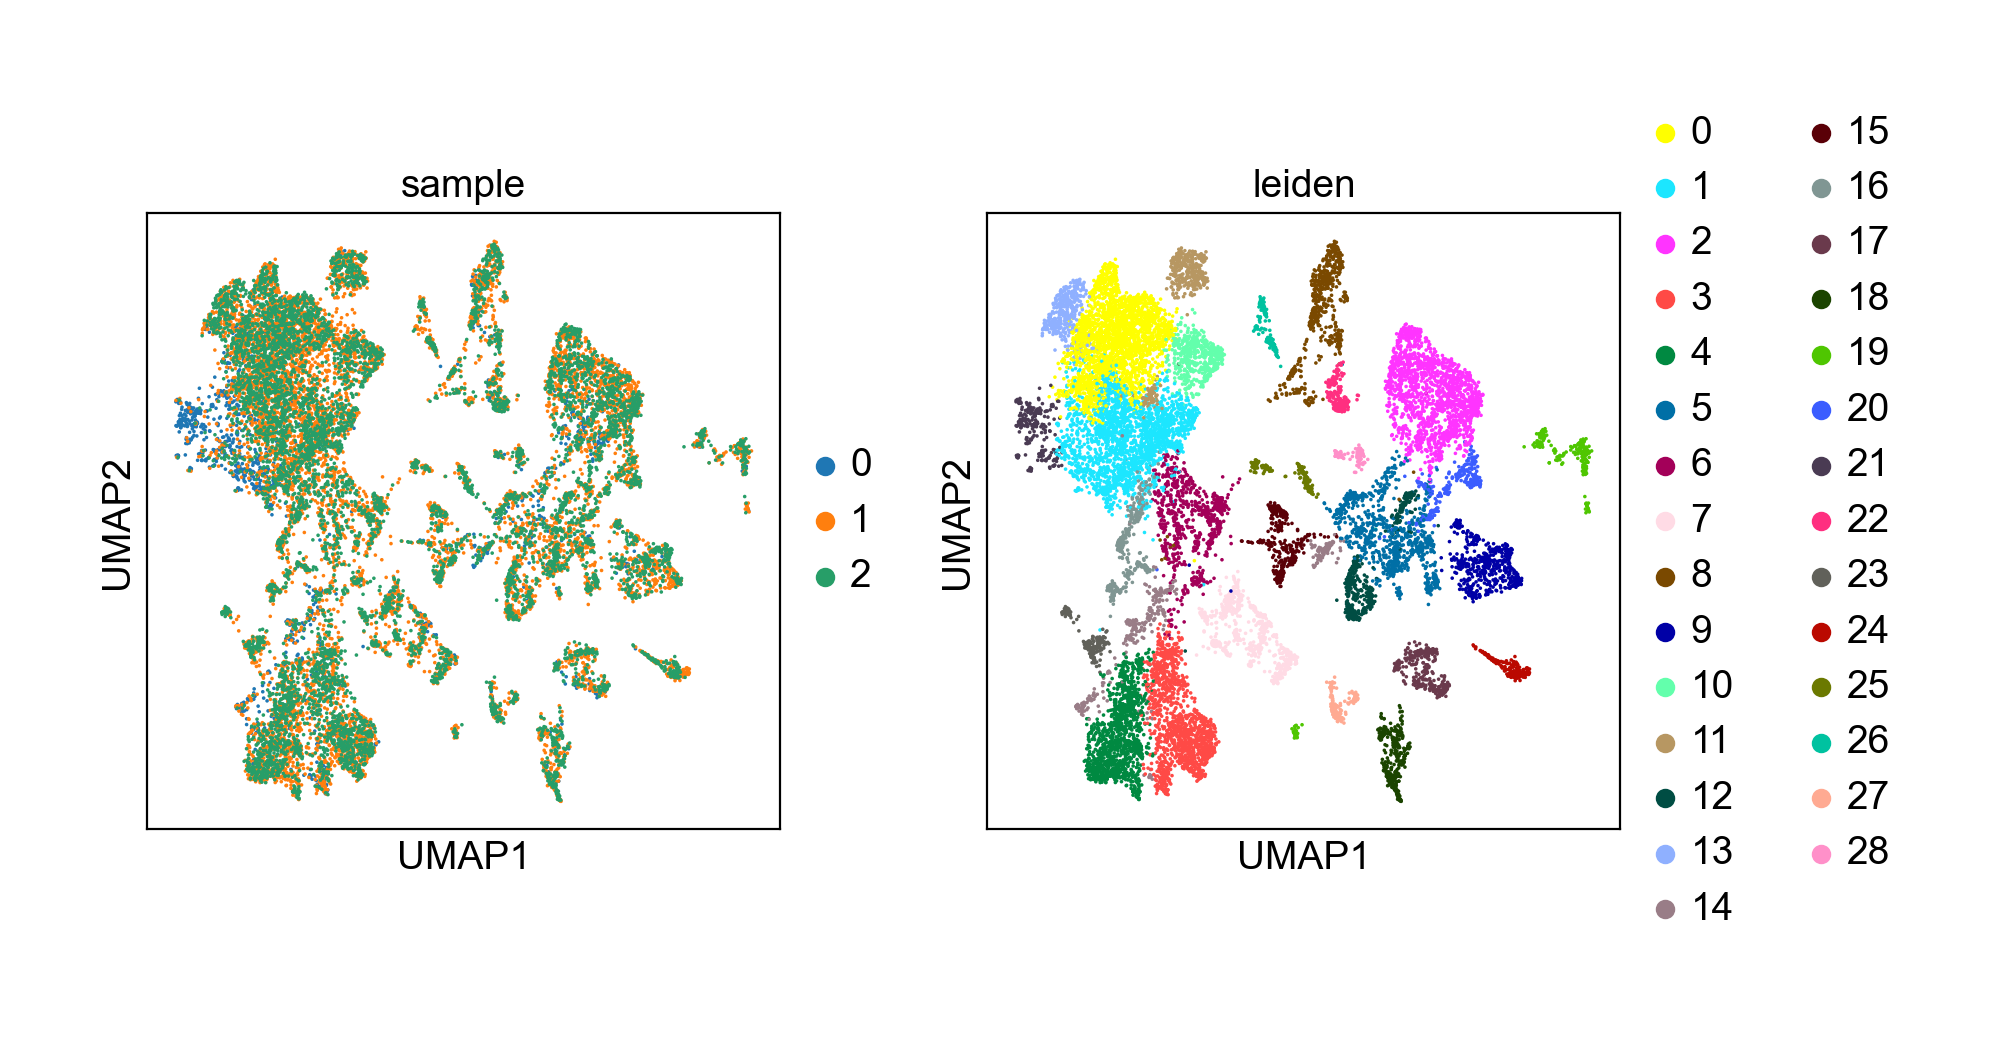

In [47]:
# Verify the three batches were well integrated 
white_plotting()
sc.pl.umap(adata, color=["sample", "leiden"])

## Plot Marker Genes

In [48]:
# Marker Gene DF 
# OSN: HsOrco 
# Neuron: Nsyb - LOC105189534
# Ammonia Sensory: Rh50 - LOC105188823
# Mechanosensory: NompC - LOC105188598
# Glia: Repo - LOC105181500 
# Muscle: MHC - LOC105191850
# Epithelium: GRH - LOC105181616
# Neural Support Cells: Sv - LOC105187024

marker_genes = ["LOC105189534", "HsOrco", "LOC105188598", "LOC105181500", "LOC105191850", "LOC105181616", "LOC105187024"]
marker_clusters = ["Neuron", "OSN", "Mechanosensory", "Glia", "Muscle", "Epithelium", "Neural Support Cells"]
marker_gene_df = pd.DataFrame({"cluster": marker_clusters, "gene": marker_genes})
marker_gene_df

cluster          gene
0                Neuron  LOC105189534
1                   OSN        HsOrco
2        Mechanosensory  LOC105188598
3                  Glia  LOC105181500
4                Muscle  LOC105191850
5            Epithelium  LOC105181616
6  Neural Support Cells  LOC105187024

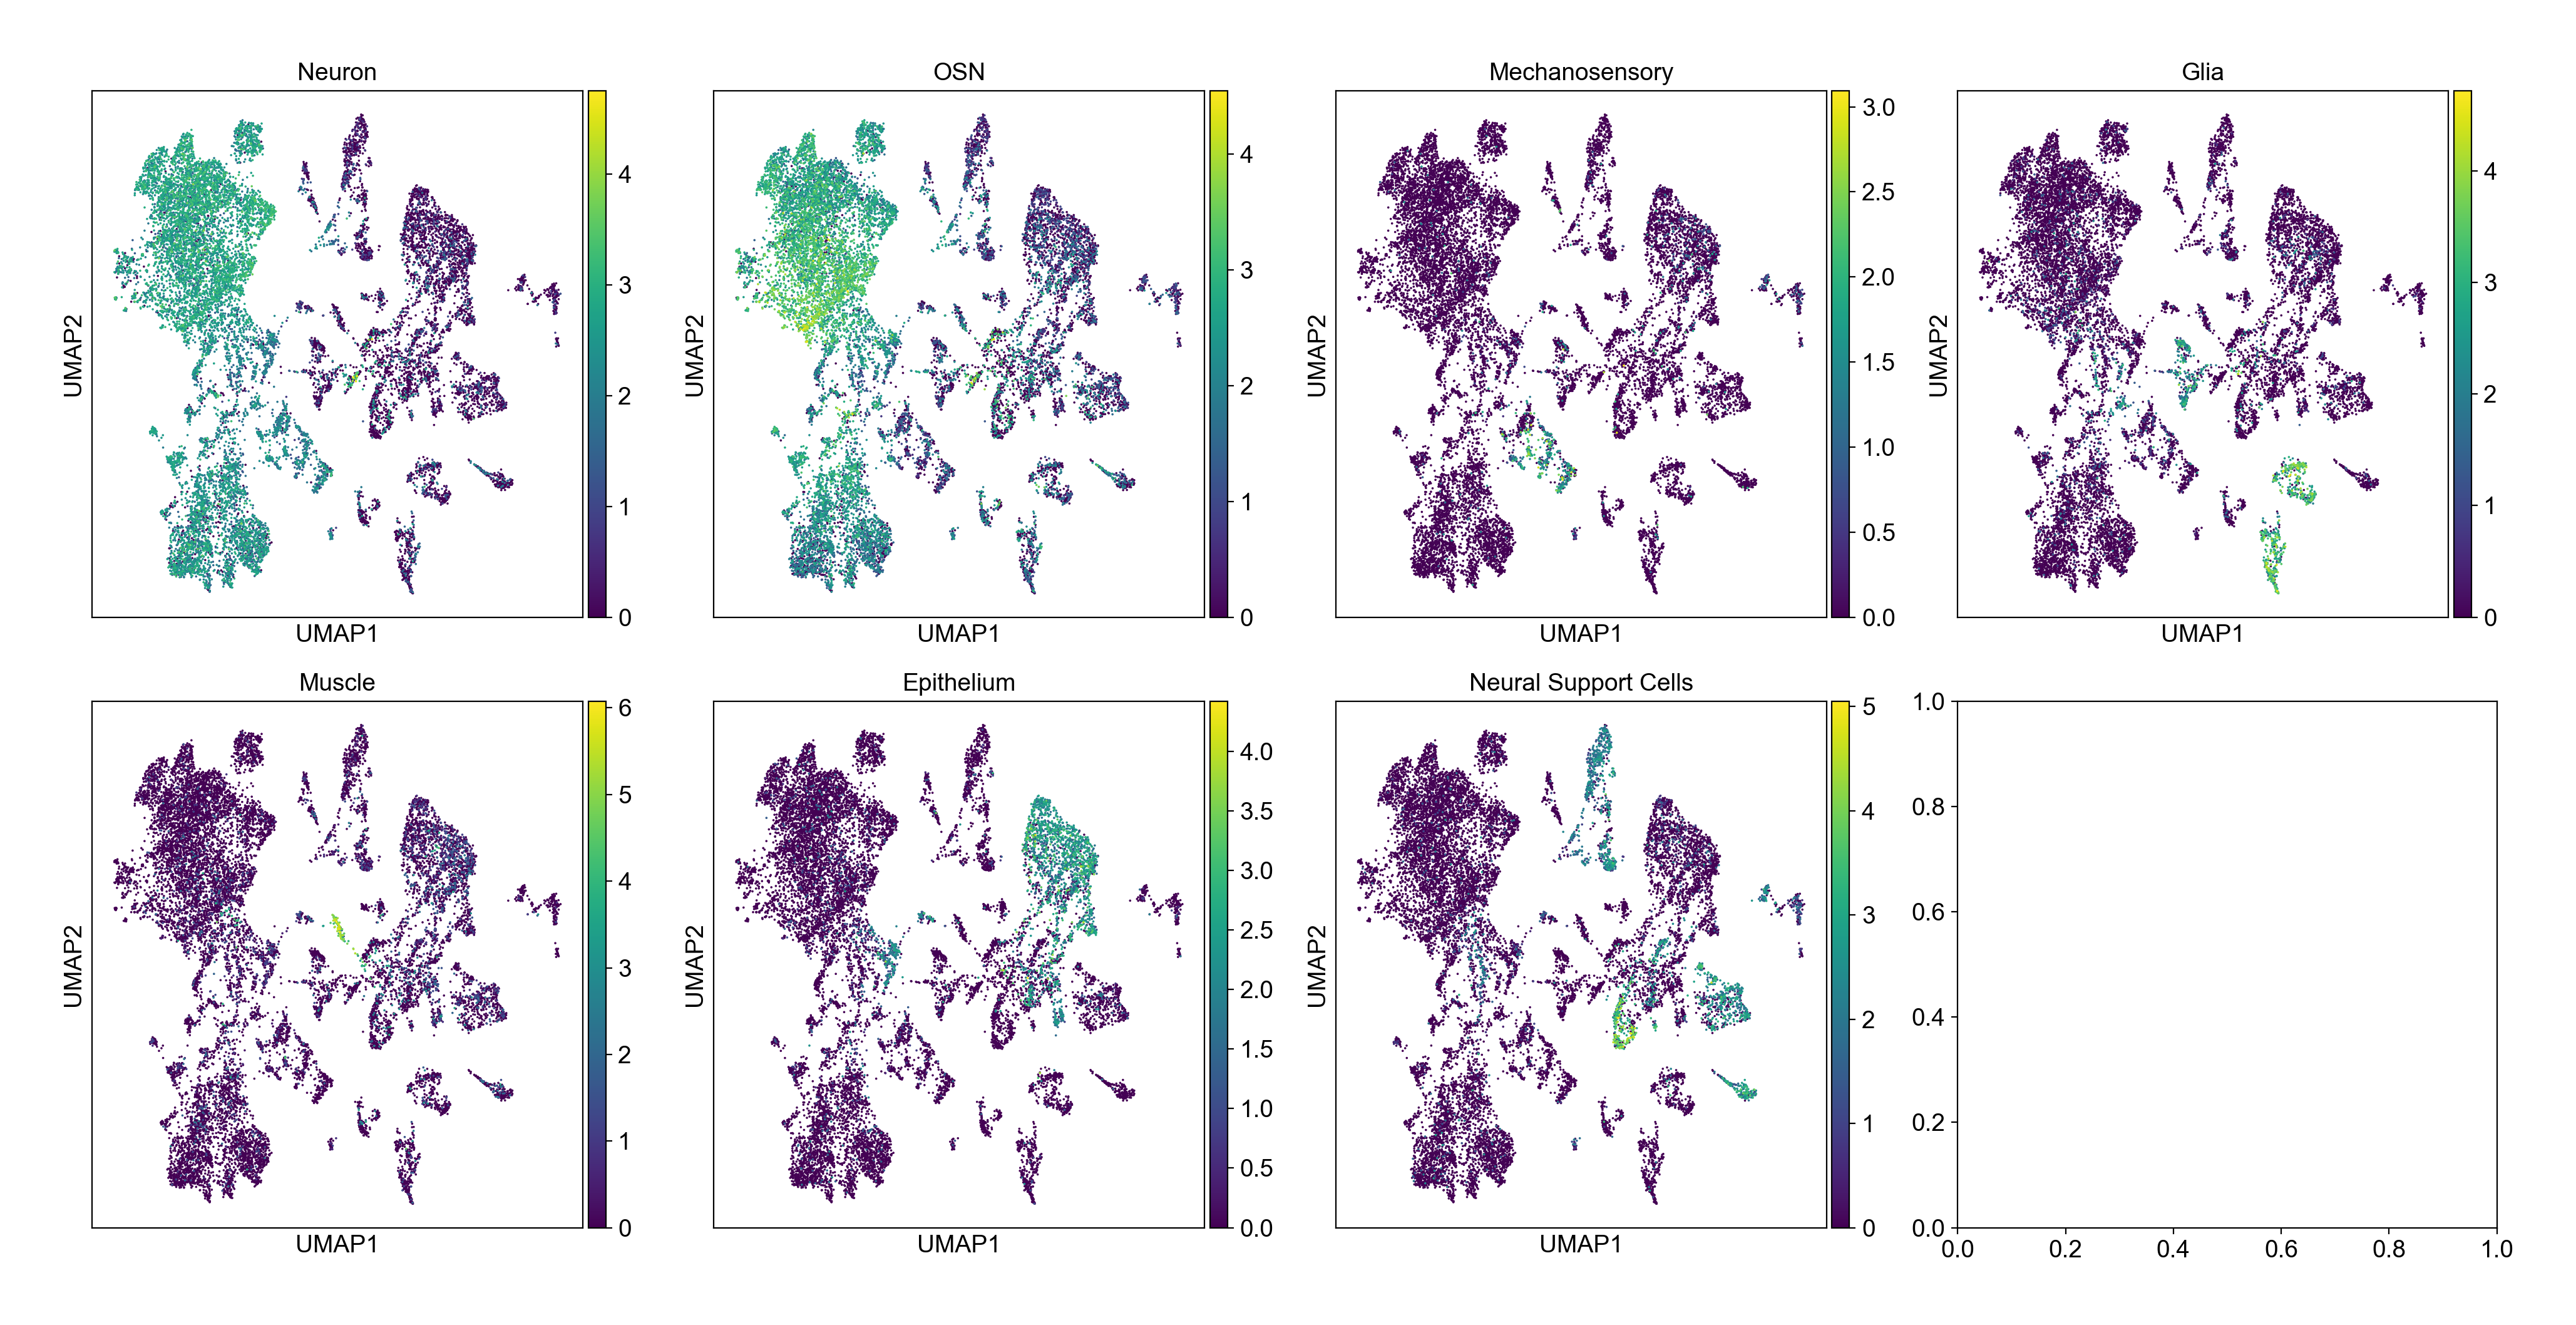

In [49]:
# Plot Marker Genes UMAPs 
white_plotting()
f, ax = plt.subplots(2, 4, figsize=(20, 10))
for i, gene in enumerate(marker_genes):
    sc.pl.umap(adata, color=gene, ax=ax.flatten()[i], show=False, legend_loc="on data", title=marker_clusters[i], cmap="viridis")
plt.tight_layout()
plt.show()

## Save Tandem Array to Data

In [50]:
or_db['in_data'] = or_db['gene_name'].isin(adata.var_names)
or_db  = or_db[or_db['in_data']]

In [51]:
# Make a dataframe with cell ID in a column and individual columns for each OR 
cell_or_expression = pd.DataFrame(index=adata.obs.index, columns=or_db.gene_name)
for i, row in or_db.iterrows(): 
    cell_or_expression[row.gene_name] = adata[:,row['gene_name']].X.toarray().flatten()

In [52]:
# Tandem array based assignment
tandem_array_matrix = pd.DataFrame(0, index=adata.obs_names, columns=or_db['tandem_array'].unique().astype(str))
for array in or_db['tandem_array'].unique():
    tandem_array_matrix[array] = adata[:, or_db[or_db['tandem_array'] == array]['gene_name']].X.sum(axis=1)

# Add the tandem array matrix to the data 
adata.obsm['tandem_array'] = tandem_array_matrix.values

# Assign clusters to cells based on the tandem array with the highest expression
adata.obs['tandem_array_cluster'] = tandem_array_matrix.idxmax(axis=1).values.astype(str) 

## Staircase Example Figure

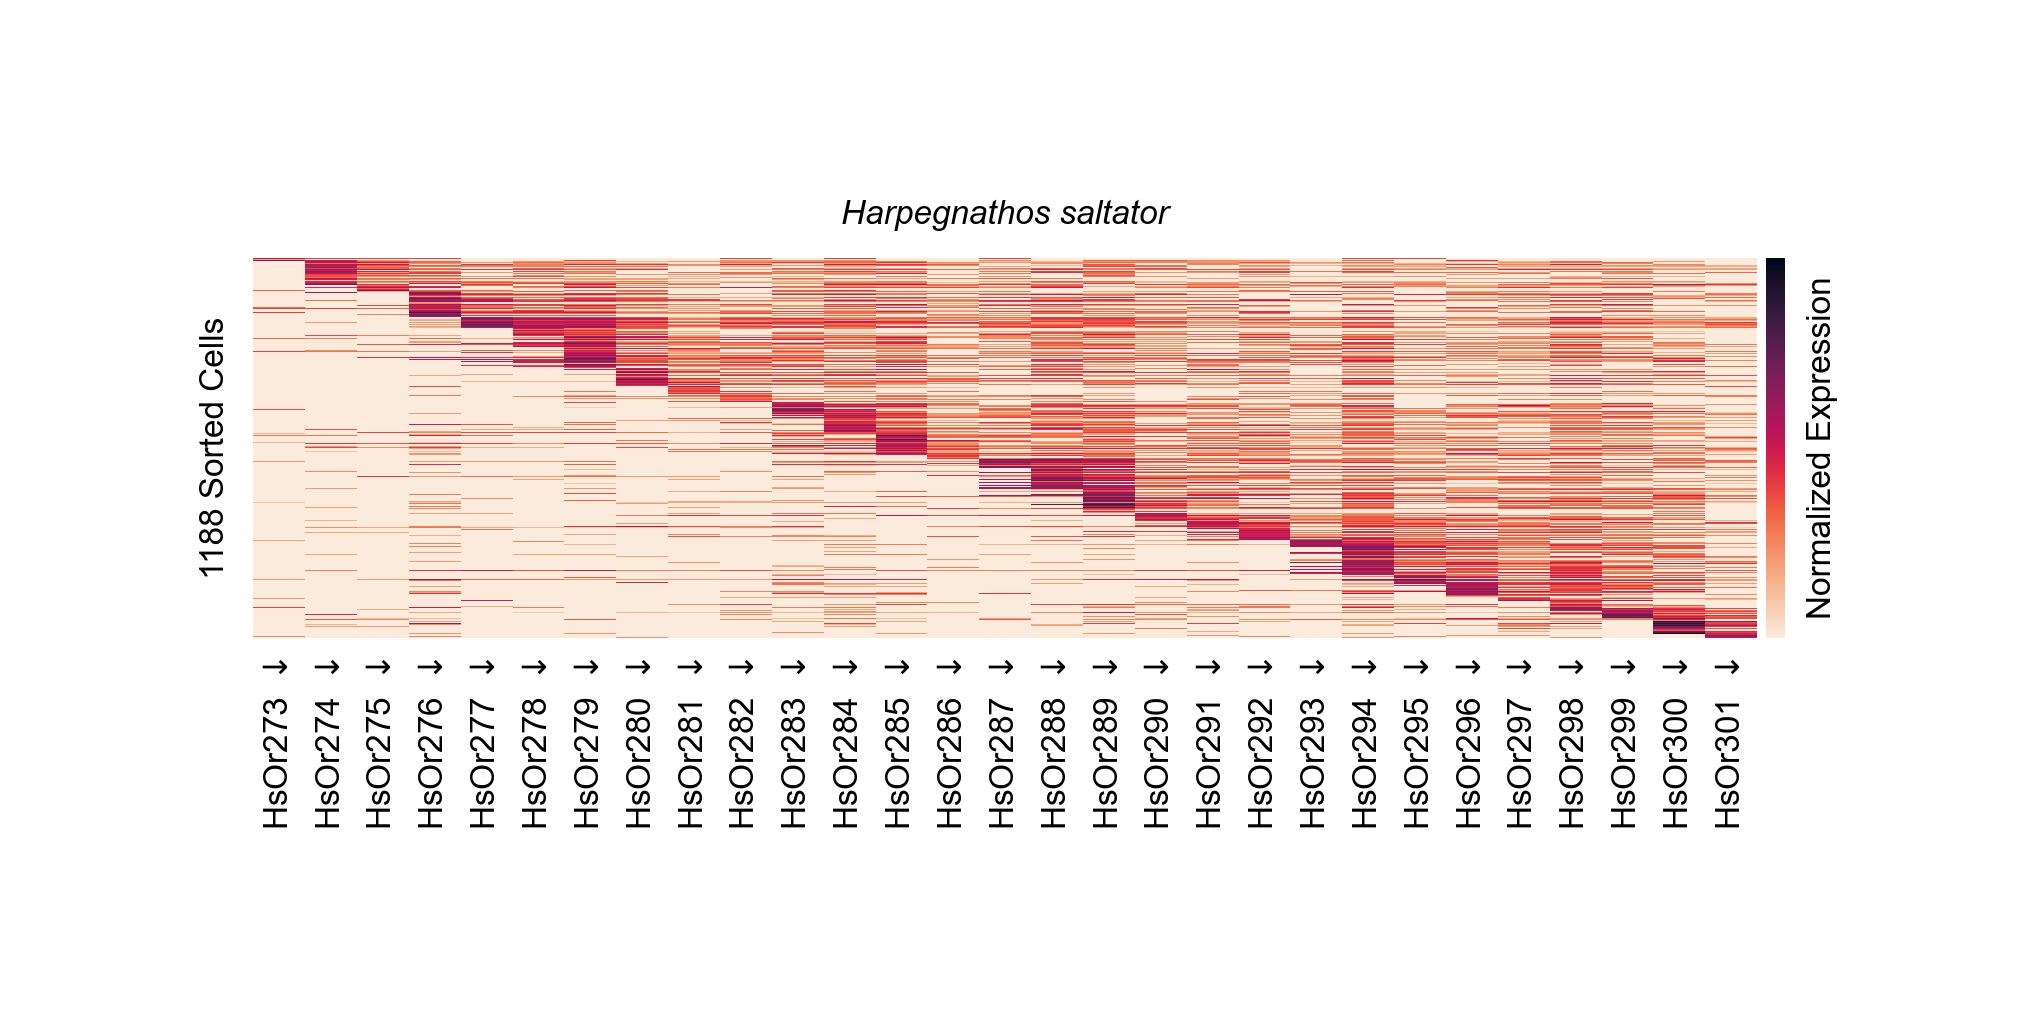

In [53]:
TA = 5

subset = or_db[or_db.tandem_array == TA]
genes = subset.gene_name.values
cells = adata[adata.obs['tandem_array_cluster'] == str(TA)]
expression = pd.DataFrame(cells[:, genes].X.toarray(), columns=genes, index=cells.obs_names)
expression['top_or'] = expression.idxmax(axis=1)
expression['top_or'] = pd.Categorical(expression['top_or'], categories=genes, ordered=True)
expression = expression.sort_values('top_or', ascending=True)

# Plot a heatmap of the expression data, with or_db gene order on the x axis and expression on the y axis
white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fig, ax = plt.subplots(1, 1, figsize=(5, 2), dpi=200)
sns.heatmap(expression.iloc[:, :-1], 
            cmap=sns.color_palette("rocket_r", as_cmap=True), 
            ax=ax, 
            xticklabels=True, 
            yticklabels=False, 
            cbar_kws={'pad': 0.005}, 
            linewidths=0,
            )

cbar = ax.collections[0].colorbar
cbar.set_ticks([])
cbar.set_label('Normalized Expression', fontsize=6) 

ax.set_ylabel(f'{cells.shape[0]} Sorted Cells', fontsize=6)
ax.set_xlabel('')
#ax.set_title(f'Tandem Array {TA} Expression (Harpegnathos saltator)', fontsize=6)
# italic 
ax.set_title(f'Harpegnathos saltator', fontsize=6, style='italic')

# Modify the x-tick labels: Remove Or5- prefix and add orientation
xticks = ax.get_xticks()
xticklabels = [x.get_text() for x in ax.get_xticklabels()]
xticklabels = [f"{x} {tr.get_gene(x).strand}" for x in xticklabels]
#xticklabels = [f"{tr.get_gene(x).strand}" for x in xticklabels]
#xticklabels = [re.sub('HsOr','OR',x) for x in xticklabels]
xticklabels = [re.sub(r'(-)', r'$\\uparrow$', x) for x in xticklabels]
xticklabels = [re.sub(r'(\+)', r'$\\downarrow$', x) for x in xticklabels]
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=90, fontsize=6)
# hide x ticks 
ax.xaxis.set_ticks_position('none')

ax.tick_params(axis='x', which='major', pad=0)
ax.grid(False)

plt.tight_layout()
plt.savefig(f"../figures/Hsalt-T5-staircase.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

plt.show()

## Look for nested lncRNAs 

In [54]:
all_genes = [tr_ncbi.get_gene(gene) for gene in tr_ncbi.genes.keys() if len(tr_ncbi.get_gene(gene).transcripts) > 0]
all_lncRNAs = [gene for gene in all_genes if gene.transcript_biotype == 'lnc_RNA']
len(all_lncRNAs), len(all_genes)

(1029, 14020)

In [55]:
def overlapping(chr1, start1, end1, chr2, start2, end2):
    return chr1 == chr2 and not (end1 < start2 or end2 < start1)

In [56]:
# Find nested lncRNAs within TAs 
or_db_no_orco = or_db.loc[~or_db.gene_name.str.contains('HsOrco')].reset_index(drop=True)

TAs = or_db_no_orco['tandem_array'].unique()
nested_lncRNAs = [] 

for ta_ in TAs: 
    # Get bounds of tandem array 
    TA_genes = or_db_no_orco.loc[or_db_no_orco['tandem_array'] == int(ta_)]
    # sort by start
    TA_genes = TA_genes.sort_values(by='start').reset_index(drop=True)
    TA_genes = TA_genes['gene_name']
    TA_chromosome = tr.get_gene(TA_genes.iloc[0]).chromosome
    first_gene_bounds = tr.get_gene(TA_genes.iloc[0]).get_transcript_longest_bounds().get_bounds()
    last_gene_bounds = tr.get_gene(TA_genes.iloc[-1]).get_transcript_longest_bounds().get_bounds()
    TA_bounds = [first_gene_bounds[0], last_gene_bounds[1]]
    
    for lncRNA in all_lncRNAs: 
        lnc_start, lnc_end = lncRNA.get_transcript_longest_bounds().get_bounds()
        lnc_strand = lncRNA.strand 
        #if lnc_start >= TA_bounds[0] and lnc_end <= TA_bounds[1] and lncRNA.chromosome == TA_chromosome: 
        if overlapping(TA_chromosome, TA_bounds[0], TA_bounds[1], lncRNA.chromosome, lnc_start, lnc_end):
            lnc_size = lnc_end - lnc_start
            nested_lncRNAs.append({'gene_name': lncRNA.name, 'TA': ta_, 'TA_location': f"{TA_chromosome}:{TA_bounds[0]}-{TA_bounds[1]}", 'lnc_strand': lnc_strand, 'lnc_size': lnc_size, 'lnc_start': lnc_start, 'lnc_end': lnc_end})

nested_lncRNAs = pd.DataFrame(nested_lncRNAs)
nested_lncRNAs

gene_name  TA                     TA_location lnc_strand  lnc_size  \
0   LOC112589535   1  NW_020229890.1:1212870-1424437          +      5242   
1   LOC109504322   3    NW_020229910.1:510020-673088          +      1260   
2   LOC109504323   3    NW_020229910.1:510020-673088          +      1155   
3   LOC112588178  12    NW_020229948.1:227684-260913          -       892   
4   LOC112588179  12    NW_020229948.1:227684-260913          -      4222   
..           ...  ..                             ...        ...       ...   
10  LOC112589800   5  NW_020230432.1:1083586-1199647          -       726   
11  LOC109503640   4     NW_020230518.1:45837-228988          -      2496   
12  LOC112589985   4     NW_020230518.1:45837-228988          -      8447   
13  LOC112590016  10    NW_020230531.1:535824-571041          -     32549   
14  LOC112590470  15      NW_020230679.1:18906-52258          -       820   

    lnc_start  lnc_end  
0     1339657  1344899  
1      650648   651908  
2      659698   660853  
3      233470   234362  
4      229025   233247  
..        ...      ...  
10    1095418  1096144  
11     159896   162392  
12     212377   220824  
13     522288   554837  
14      30558    31378  

[15 rows x 7 columns]

In [57]:
# Remove lncRNAs that are not in the data 
nested_lncRNAs['in_data'] = nested_lncRNAs['gene_name'].isin(adata.var.index)
print(f"Identified {nested_lncRNAs['in_data'].sum()} nested lncRNAs in the data")
nested_lncRNAs = nested_lncRNAs[nested_lncRNAs['in_data']]
nested_lncRNAs.reset_index(drop=True, inplace=True)

Identified 12 nested lncRNAs in the data


Filter for lncRNAs present in both single cell datasets

In [58]:
# Remove lncRNAs that are not in the data 
nested_lncRNAs['in_data'] = nested_lncRNAs['gene_name'].isin(adata.var.index)
nested_lncRNAs = nested_lncRNAs.loc[nested_lncRNAs['in_data']]
nested_lncRNAs = nested_lncRNAs.reset_index(drop=True)
nested_lncRNAs.shape

(12, 8)

Identify the two ORs that flank the lncRNA 

In [59]:
or_db_no_orco = or_db[~or_db['gene_name'].str.contains('Or2')]
or_db_no_orco.shape

(260, 14)

In [60]:
# For each nested lncRNA, find all ORs that are upstream or downstream of the lncRNA TSS within the TA 
lnc_associated_ORs = [] 

for i, row in nested_lncRNAs.iterrows():
    # Get ORs in the TA
    TA_genes = or_db_no_orco.loc[or_db_no_orco['tandem_array'] == int(row.TA), 'gene_name']
    ORs_of_interest = [] 
    # For each gene, check if it is upstream or downstream of the lncRNA
    for gene in TA_genes: 
        gene_obj = tr.get_gene(gene) 
        gene_start, gene_end = gene_obj.get_transcript_longest_bounds().get_bounds()
        gene_strand = gene_obj.strand
        # Verify that the OR and lncRNA are on opposite strands 
        if gene_strand == row.lnc_strand: 
            continue 
        if gene_strand == "-" and row.lnc_strand == "+": 
            if gene_end < row.lnc_start: 
                ORs_of_interest.append([gene, "upstream", row.lnc_start - gene_start, gene_start, gene_end, gene_strand])
            elif gene_start > row.lnc_start: 
                ORs_of_interest.append([gene, "downstream", gene_start - row.lnc_start, gene_start, gene_end, gene_strand])
        elif gene_strand == "+" and row.lnc_strand == "-": 
            if gene_start > row.lnc_start: 
                ORs_of_interest.append([gene, "upstream", gene_start - row.lnc_start, gene_start, gene_end, gene_strand])
            elif gene_end < row.lnc_start: 
                ORs_of_interest.append([gene, "downstream", row.lnc_start - gene_start, gene_start, gene_end, gene_strand])
    
    # save to lnc_associated_ORs
    for or_name, location, distance, or_start, or_end, or_strand in ORs_of_interest:
        lnc_associated_ORs.append({'lncRNA': row.gene_name, 'lncRNA_size': row.lnc_size, 'TA': row.TA, 'or_name': or_name, 'location': location, 'tss2tss': distance, 'lnc_start': row.lnc_start, 'lnc_end': row.lnc_end, 'lnc_strand': row.lnc_strand, 'or_start': or_start, 'or_end': or_end, 'or_strand': or_strand})
    

lnc_associated_ORs = pd.DataFrame(lnc_associated_ORs)
lnc_associated_ORs

lncRNA  lncRNA_size  TA    or_name  location  tss2tss  lnc_start  \
0    LOC109504322         1260   3    HsOr170  upstream   140628     650648   
1    LOC109504322         1260   3    HsOr169  upstream   136839     650648   
2    LOC109504322         1260   3    HsOr168  upstream   132787     650648   
3    LOC109504322         1260   3    HsOr167  upstream   128541     650648   
4    LOC109504322         1260   3  HsOr131.1  upstream   124358     650648   
..            ...          ...  ..        ...       ...      ...        ...   
161  LOC112590016        32549  10    HsOr196  upstream    32731     522288   
162  LOC112590016        32549  10    HsOr195  upstream    36620     522288   
163  LOC112590016        32549  10    HsOr194  upstream    40096     522288   
164  LOC112590016        32549  10    HsOr193  upstream    42405     522288   
165  LOC112590016        32549  10    HsOr192  upstream    46333     522288   

     lnc_end lnc_strand  or_start  or_end or_strand  
0     651908          +    510020  512994         -  
1     651908          +    513809  516687         -  
2     651908          +    517861  520571         -  
3     651908          +    522107  525599         -  
4     651908          +    526290  530310         -  
..       ...        ...       ...     ...       ...  
161   554837          -    555019  557779         +  
162   554837          -    558908  561398         +  
163   554837          -    562384  564643         +  
164   554837          -    564693  567419         +  
165   554837          -    568621  571041         +  

[166 rows x 12 columns]

Measure expression of the OR in cells expressing the lncRNA, for both snRNAseq datasets

In [61]:
# For cells that express each lncRNA, measure the expression of the OR 
unique_lncs = lnc_associated_ORs['lncRNA'].unique()
lnc_associated_ORs['OR_coexpression'] = None
for unique_lnc in unique_lncs: 
    lnc_cell_indices = adata[:, unique_lnc].X > 0
    if lnc_cell_indices.sum() == 0: 
        continue
    for i, row in lnc_associated_ORs.loc[lnc_associated_ORs['lncRNA'] == unique_lnc].iterrows(): 
        or_coexpression = adata[lnc_cell_indices, row['or_name']].X.mean()
        lnc_associated_ORs.at[i, 'OR_coexpression'] = or_coexpression if or_coexpression > 0 else 0

lnc_associated_ORs

lncRNA  lncRNA_size  TA    or_name  location  tss2tss  lnc_start  \
0    LOC109504322         1260   3    HsOr170  upstream   140628     650648   
1    LOC109504322         1260   3    HsOr169  upstream   136839     650648   
2    LOC109504322         1260   3    HsOr168  upstream   132787     650648   
3    LOC109504322         1260   3    HsOr167  upstream   128541     650648   
4    LOC109504322         1260   3  HsOr131.1  upstream   124358     650648   
..            ...          ...  ..        ...       ...      ...        ...   
161  LOC112590016        32549  10    HsOr196  upstream    32731     522288   
162  LOC112590016        32549  10    HsOr195  upstream    36620     522288   
163  LOC112590016        32549  10    HsOr194  upstream    40096     522288   
164  LOC112590016        32549  10    HsOr193  upstream    42405     522288   
165  LOC112590016        32549  10    HsOr192  upstream    46333     522288   

     lnc_end lnc_strand  or_start  or_end or_strand OR_coexpression  
0     651908          +    510020  512994         -        0.160275  
1     651908          +    513809  516687         -        0.383554  
2     651908          +    517861  520571         -        0.253667  
3     651908          +    522107  525599         -        0.158971  
4     651908          +    526290  530310         -        0.246417  
..       ...        ...       ...     ...       ...             ...  
161   554837          -    555019  557779         +        0.760354  
162   554837          -    558908  561398         +        0.473487  
163   554837          -    562384  564643         +        0.308841  
164   554837          -    564693  567419         +        0.481899  
165   554837          -    568621  571041         +        0.407396  

[166 rows x 13 columns]

Adjust distances so that upstream is negative and downstream is positive

In [62]:
lnc_associated_ORs['distance_adjusted'] = lnc_associated_ORs.apply(lambda x: x['tss2tss'] if x['location'] == 'downstream' else -x['tss2tss'], axis=1)
lnc_associated_ORs

lncRNA  lncRNA_size  TA    or_name  location  tss2tss  lnc_start  \
0    LOC109504322         1260   3    HsOr170  upstream   140628     650648   
1    LOC109504322         1260   3    HsOr169  upstream   136839     650648   
2    LOC109504322         1260   3    HsOr168  upstream   132787     650648   
3    LOC109504322         1260   3    HsOr167  upstream   128541     650648   
4    LOC109504322         1260   3  HsOr131.1  upstream   124358     650648   
..            ...          ...  ..        ...       ...      ...        ...   
161  LOC112590016        32549  10    HsOr196  upstream    32731     522288   
162  LOC112590016        32549  10    HsOr195  upstream    36620     522288   
163  LOC112590016        32549  10    HsOr194  upstream    40096     522288   
164  LOC112590016        32549  10    HsOr193  upstream    42405     522288   
165  LOC112590016        32549  10    HsOr192  upstream    46333     522288   

     lnc_end lnc_strand  or_start  or_end or_strand OR_coexpression  \
0     651908          +    510020  512994         -        0.160275   
1     651908          +    513809  516687         -        0.383554   
2     651908          +    517861  520571         -        0.253667   
3     651908          +    522107  525599         -        0.158971   
4     651908          +    526290  530310         -        0.246417   
..       ...        ...       ...     ...       ...             ...   
161   554837          -    555019  557779         +        0.760354   
162   554837          -    558908  561398         +        0.473487   
163   554837          -    562384  564643         +        0.308841   
164   554837          -    564693  567419         +        0.481899   
165   554837          -    568621  571041         +        0.407396   

     distance_adjusted  
0              -140628  
1              -136839  
2              -132787  
3              -128541  
4              -124358  
..                 ...  
161             -32731  
162             -36620  
163             -40096  
164             -42405  
165             -46333  

[166 rows x 14 columns]

In [63]:
# get unique lncRNAs
lnc_associated_ORs['lncRNA'].unique()

array(['LOC109504322', 'LOC109504323', 'LOC112588178', 'LOC112588179',
       'LOC112589800', 'LOC109503640', 'LOC112589985', 'LOC112590016'],
      dtype=object)

In [64]:
lncRNA = 'LOC109504322'
rows = lnc_associated_ORs.loc[lnc_associated_ORs['lncRNA'] == lncRNA]
upstream_ORs = rows.loc[rows['location'] == 'upstream']['or_name'].values
downstream_ORs = rows.loc[rows['location'] == 'downstream']['or_name'].values
rows

lncRNA  lncRNA_size  TA    or_name    location  tss2tss  lnc_start  \
0   LOC109504322         1260   3    HsOr170    upstream   140628     650648   
1   LOC109504322         1260   3    HsOr169    upstream   136839     650648   
2   LOC109504322         1260   3    HsOr168    upstream   132787     650648   
3   LOC109504322         1260   3    HsOr167    upstream   128541     650648   
4   LOC109504322         1260   3  HsOr131.1    upstream   124358     650648   
..           ...          ...  ..        ...         ...      ...        ...   
33  LOC109504322         1260   3    HsOr161    upstream     5946     650648   
34  LOC109504322         1260   3    HsOr163  downstream     3008     650648   
35  LOC109504322         1260   3    HsOr164  downstream     6577     650648   
36  LOC109504322         1260   3    HsOr165  downstream    10777     650648   
37  LOC109504322         1260   3    HsOr166  downstream    16414     650648   

    lnc_end lnc_strand  or_start  or_end or_strand OR_coexpression  \
0    651908          +    510020  512994         -        0.160275   
1    651908          +    513809  516687         -        0.383554   
2    651908          +    517861  520571         -        0.253667   
3    651908          +    522107  525599         -        0.158971   
4    651908          +    526290  530310         -        0.246417   
..      ...        ...       ...     ...       ...             ...   
33   651908          +    644702  647980         -        0.203967   
34   651908          +    653656  656585         -        0.029719   
35   651908          +    657225  659824         -        0.005875   
36   651908          +    661425  666008         -        0.022521   
37   651908          +    667062  673088         -        0.034916   

    distance_adjusted  
0             -140628  
1             -136839  
2             -132787  
3             -128541  
4             -124358  
..                ...  
33              -5946  
34               3008  
35               6577  
36              10777  
37              16414  

[38 rows x 14 columns]

Chromosome: NW_020229910.1, Start: 509920, End: 673188


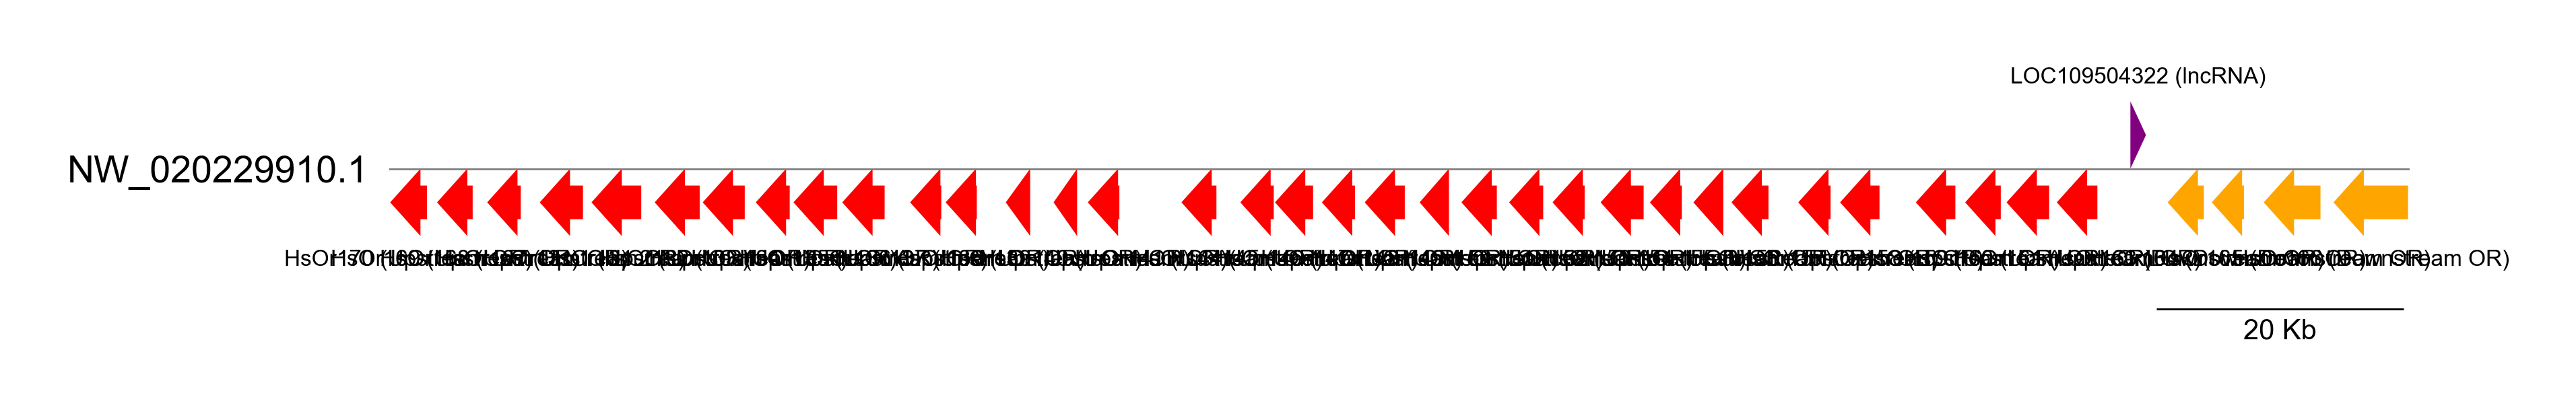

In [65]:
chromosome = tr.get_gene(lncRNA).chromosome
start = min(rows.or_start)-100
end = max(rows.or_end)+100
print(f"Chromosome: {chromosome}, Start: {start}, End: {end}")

white_plotting()
gv = GenomeViz(track_align_type="center", theme="light")
gv.set_scale_bar(ymargin=0.5)

fontsize=12 

# Get bounds 
track = gv.add_feature_track(chromosome, segments = (int(start), int(end)))
#track.add_sublabel(size=fontsize)

# Add gene models to plot 
for gene in [lncRNA] + list(upstream_ORs) + list(downstream_ORs):
    transcript = tr.get_gene(gene).get_transcript_longest_bounds()
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    if gene in upstream_ORs:
        color = 'red'
        label = f'{gene} (Upstream OR)'
    elif gene in downstream_ORs:
        color = 'orange'
        label = f'{gene} (Downstream OR)'
    elif gene == lncRNA: 
        color = 'purple'
        label = f'{gene} (lncRNA)'
    else: 
        color = 'grey'
        label = gene
        
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        text_kws={'color': 'black', 
                  'rotation': 0, 
                  'vpos': vpos, 
                  'hpos': 'center', 
                  'size':fontsize}
    )

fig = gv.plotfig()
plt.show()

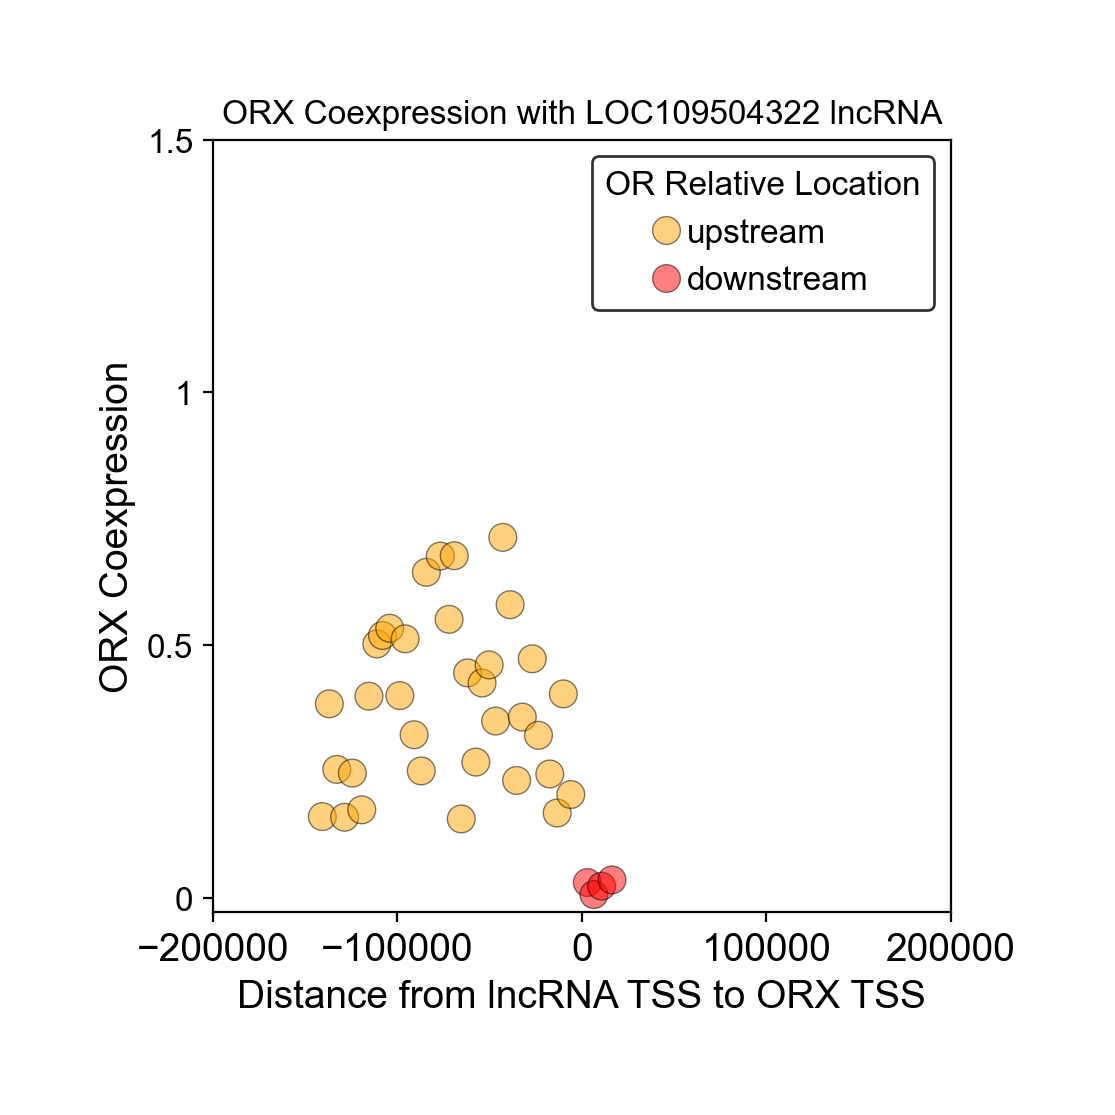

In [66]:
# Scatter plot of coexpression vs distance_adjusted, two subplots for P1 and P14, with KDE 
white_plotting()
fontsize=12
f, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
palette=['orange', 'red']
sns.scatterplot(data=rows, x='distance_adjusted', y="OR_coexpression", ax=ax, hue='location', hue_order=['upstream', 'downstream'], palette=palette, s=100, legend=True, lw=0.5, edgecolor='black', alpha=0.5)
ax.set_xlabel('Distance from lncRNA TSS to ORX TSS')
ax.set_ylabel('ORX Coexpression')
ax.set_title(f'ORX Coexpression with {lncRNA} lncRNA', fontsize=fontsize)
ax.set_xlim(-200_000, 200_000)
#ax.set_xticks([-20_000, -10_000, 0, 10_000, 20_000])
#ax.set_xticklabels(['-20kb', '-10kb', '0', '10kb', '20kb'], fontsize=fontsize)
ax.legend(title='OR Relative Location', loc='upper right', fontsize=fontsize, title_fontsize=fontsize)
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_yticklabels([0, 0.5, 1, 1.5], fontsize=fontsize)

plt.tight_layout()
plt.show()

In [67]:
# Plot the number of lncRNAs split by TA 
ta, counts = np.unique(nested_lncRNAs['TA'], return_counts=True)
counts = pd.DataFrame({'TA': ta, 'num_lnc': counts})
counts = counts.sort_values(by='num_lnc', ascending=False).reset_index(drop=True)
counts['num_ORs'] = counts['TA'].apply(lambda x: or_db_no_orco.loc[or_db_no_orco.tandem_array == x].shape[0])
counts

TA  num_lnc  num_ORs
0   3        2       39
1   4        2       37
2  12        2        3
3   2        1       44
4   5        1        2
5  10        1        8
6  14        1        8
7  18        1        0
8  22        1        1

In [68]:
sum(counts['num_lnc'])

12

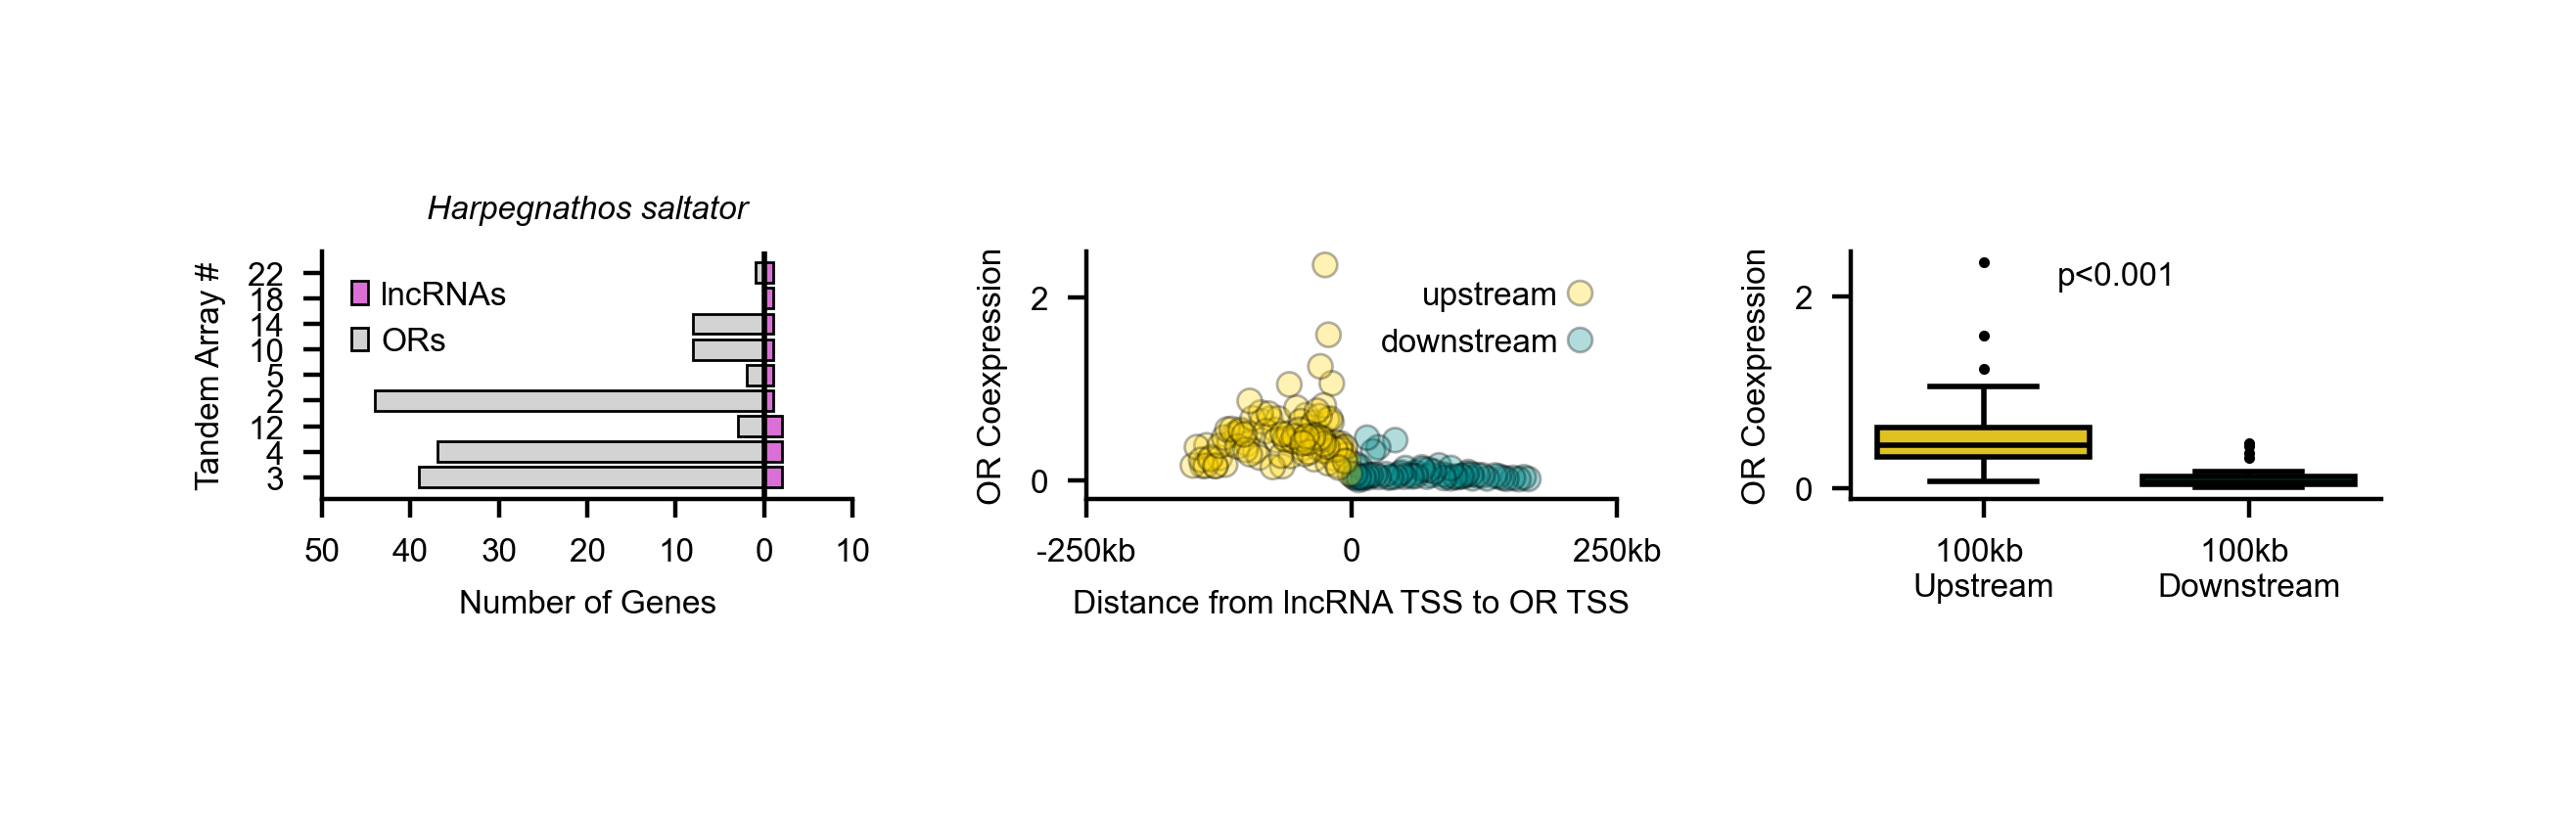

In [69]:
# Scatter plot of coexpression vs distance_adjusted, two subplots for P1 and P14, with KDE 
white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fontsize=6
f, axs = plt.subplots(1, 3, figsize=(6, 1.5), dpi=200)

ax = axs[0]

y_labels = counts['TA']
y_pos = np.arange(len(y_labels))

ax.barh(y_pos, counts['num_lnc'], color='orchid', label='lncRNAs', linewidth=0.5, edgecolor='black')
ax.barh(y_pos, -counts['num_ORs'], color='lightgrey', label='ORs', linewidth=0.5, edgecolor='black')

# Y axis 
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels, fontsize=fontsize)
ax.set_ylabel('Tandem Array #', fontsize=fontsize)
ax.set_title("Harpegnathos saltator", fontsize=fontsize, style='italic')

# X labels 
ax.set_xticks([-50, -40, -30, -20, -10, 0, 10], labels=[50, 40, 30, 20, 10, 0, 10], fontsize=fontsize)
ax.set_xlabel('')
ax.axvline(0, color='black', linewidth=1) 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Number of Genes", fontsize=fontsize)
ax.legend(loc='upper left', fontsize=fontsize, frameon=False)

palette=['gold', 'darkcyan']
ax = axs[1]
sns.scatterplot(data=lnc_associated_ORs, x='distance_adjusted', y="OR_coexpression", ax=ax, hue='location', hue_order=['upstream', 'downstream'], palette=palette, s=20, legend=True, lw=0.5, edgecolor='black', alpha=0.3)
ax.set_xlabel('Distance from lncRNA TSS to OR TSS', fontsize=fontsize)
ax.set_ylabel('OR Coexpression', fontsize=fontsize)
ax.set_xlim(-250_000, 250_000)
ax.set_xticks([-250_000, 0, 250_000], labels=['-250kb', '0', '250kb'], fontsize=fontsize)
ax.set_yticks([0, 2], labels=[0, 2], fontsize=fontsize)
ax.set_ylim(-0.2, 2.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc='upper right', fontsize=fontsize, frameon=False, markerfirst=False)

ax = axs[2]
max_distance = 100_000
data_subset=lnc_associated_ORs[lnc_associated_ORs['tss2tss'] < max_distance]
labels = ['100kb \nUpstream', '100kb \nDownstream']
# Plot box plot of OR coexpression by location and add stats 
bx = sns.boxplot(data=data_subset, x='location', y='OR_coexpression', ax=ax, palette=palette, hue_order=['upstream', 'downstream'], order=['upstream', 'downstream'], linewidth=1, linecolor='black', fliersize=1)
ax.set_xlabel('')
ax.set_ylabel('OR Coexpression', fontsize=fontsize)
ax.set_xticks([0, 1], labels=labels, fontsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 2], labels=[0, 2], fontsize=fontsize)

# Rank sum test 
upstream = data_subset.loc[data_subset['location'] == 'upstream', 'OR_coexpression']
downstream = data_subset.loc[data_subset['location'] == 'downstream', 'OR_coexpression']
from scipy.stats import ranksums
stat, p = ranksums(upstream, downstream)
p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
plt.text(0.5, 0.9, p_value_str, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=fontsize)

plt.tight_layout()
plt.savefig(f"../figures/Hsalt-lncRNA-ORX-coexpression.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## Identify cells with valence OR in a tandem array that has a lncRNA 

In [70]:
# Make a dataframe with cell ID in a column and individual columns for each OR 
cell_or_expression = pd.DataFrame(index=adata.obs.index, columns=or_db.gene_name)
for i, row in or_db.iterrows(): 
    cell_or_expression[row.gene_name] = adata[:,row['gene_name']].X.toarray().flatten()

In [71]:
# Find the highest-expressing OR in each cell 
cell_valence_OR = cell_or_expression.idxmax(axis=1)
cell_valence_OR = cell_valence_OR.reset_index()
cell_valence_OR.columns = ['cell_index', 'valence_OR']
cell_valence_OR['tandem_array'] = cell_valence_OR['valence_OR'].apply(lambda x: or_db.loc[or_db['gene_name'] == x, 'tandem_array'].values[0])
cell_valence_OR['or_strand'] = cell_valence_OR['valence_OR'].apply(lambda x: tr.get_gene(x).strand)
cell_valence_OR

cell_index valence_OR  tandem_array or_strand
0      AAACCCAAGACTCATC-1-0     HsOr98             4         +
1      AAACCCAGTAGATTAG-1-0    HsOr295             5         +
2      AAACCCATCCACGTAA-1-0    HsOr260            20         +
3      AAACCCATCCTACGGG-1-0    HsOr330             2         +
4      AAACGAAGTTCTTAGG-1-0    HsOr324             2         +
...                     ...        ...           ...       ...
17797  TTTGTTGCATGCCGGT-1-2    HsOr205            16         +
17798  TTTGTTGGTAGTTCCA-1-2    HsOr272            11         +
17799  TTTGTTGGTATACGGG-1-2     HsOr71             6         +
17800  TTTGTTGGTCTGGTTA-1-2     HsOr30             1         -
17801  TTTGTTGGTTGGGTTT-1-2    HsOr232             7         -

[17802 rows x 4 columns]

In [72]:
# Remove cells that do not have a lncRNA in the tandem array 
cell_valence_OR = cell_valence_OR[cell_valence_OR['tandem_array'].isin(nested_lncRNAs['TA'])].reset_index(drop=True)
cell_valence_OR

cell_index valence_OR  tandem_array or_strand
0      AAACCCAAGACTCATC-1-0     HsOr98             4         +
1      AAACCCAGTAGATTAG-1-0    HsOr295             5         +
2      AAACCCATCCTACGGG-1-0    HsOr330             2         +
3      AAACGAAGTTCTTAGG-1-0    HsOr324             2         +
4      AAACGCTAGTTCAACC-1-0    HsOr319             2         +
...                     ...        ...           ...       ...
11063  TTTGGTTCAAATGATG-1-2    HsOr331             2         +
11064  TTTGGTTGTCGCATTA-1-2    HsOr323             2         +
11065  TTTGTTGCAAGTTGGG-1-2    HsOr289             5         +
11066  TTTGTTGCAGGAGGAG-1-2    HsOr308             2         +
11067  TTTGTTGCAGGTTTAC-1-2    HsOr323             2         +

[11068 rows x 4 columns]

## Assign lncRNAs to valence ORs 
- Assert that the lncRNA and valence OR are on opposite strands 
- Assert that all transcript isoforms have a 3' end that is upstream of the OR TSS 
- Assert that min distance from the lncRNA 3' end (across all transcript isoforms) to the TSS is less than 10kb 
- Only save the lncRNA with the minimum `tss_2_lnc_end` distance 
- Remove cells where no lncRNA was assigned 
- Save expression of lncRNA and valence OR for each cell 

In [73]:
# For each cell and valence OR, look for a lncRNA whose 3' end is upstream of the OR TSS and whose 5' end is closest to the OR TSS 
max_distance = 10_000
for i, row in tqdm(cell_valence_OR.iterrows(), total=cell_valence_OR.shape[0]):
    or_bounds = tr.get_gene(row['valence_OR']).get_transcript_longest_cds().get_bounds()
    or_tss = or_bounds[0] if row['or_strand'] == "+" else or_bounds[1]
    # Get lncRNAs in the TA
    relevant_lncRNAs = nested_lncRNAs[nested_lncRNAs['TA'] == row['tandem_array']]
    relevant_lncRNAs['tss2tss'] = None
    relevant_lncRNAs['all_upstream'] = None
    for j, lncRNA in relevant_lncRNAs.iterrows():
        # check that strands are opposite 
        if row['or_strand'] == lncRNA['lnc_strand']:
            continue
        # get the bounds of the lncRNA 
        lnc_transcripts = tr.get_gene(lncRNA['gene_name']).transcripts 
        end_ind = 1 if lncRNA['lnc_strand'] == "+" else 0
        lnc_ends = [transcript.get_bounds()[end_ind] for transcript in lnc_transcripts]
        lnc_starts = [transcript.get_bounds()[1-end_ind] for transcript in lnc_transcripts]
        # Check that all transcripts have a 3' end upstream of the OR TSS
        all_upstream = all([lnc_end < or_tss for lnc_end in lnc_ends]) if row['or_strand'] == "+" else all([lnc_end > or_tss for lnc_end in lnc_ends])
        if all_upstream: 
            #tss_to_tss = min([abs(or_tss - lnc_start) for lnc_start in lnc_starts])
            tss_to_tss = min([(or_tss - lnc_start) for lnc_start in lnc_starts]) if row['or_strand'] == "+" else min([lnc_start - or_tss for lnc_start in lnc_starts])
            tss_2_lnc_end = min([abs(lnc_end - or_tss) for lnc_end in lnc_ends])
            relevant_lncRNAs.at[j, 'tss_2_lnc_end'] = tss_2_lnc_end
            relevant_lncRNAs.at[j, 'tss2tss'] = tss_to_tss
            relevant_lncRNAs.at[j, 'all_upstream'] = True
    # Save the lncRNA with the smallest tss2tss
    if relevant_lncRNAs.shape[0] > 0 and np.sum(relevant_lncRNAs['all_upstream']) > 0:
        relevant_lncRNAs = relevant_lncRNAs[relevant_lncRNAs['all_upstream']==True]
        relevant_lncRNAs = relevant_lncRNAs.iloc[np.argmin(relevant_lncRNAs['tss_2_lnc_end']), :]
        # Verify tss_2_lnc_end < max_distance 
        if relevant_lncRNAs['tss_2_lnc_end'] > max_distance: 
            continue
        cell_valence_OR.at[i, 'lncRNA'] = relevant_lncRNAs['gene_name']
        cell_valence_OR.at[i, 'tss_2_lnc_end'] = relevant_lncRNAs['tss_2_lnc_end']
        cell_valence_OR.at[i, 'tss2tss'] = relevant_lncRNAs['tss2tss']
        cell_valence_OR.at[i, 'lnc_strand'] = relevant_lncRNAs['lnc_strand']

cell_valence_OR

100%|██████████| 11068/11068 [00:05<00:00, 2186.04it/s]


cell_index valence_OR  tandem_array or_strand lncRNA  \
0      AAACCCAAGACTCATC-1-0     HsOr98             4         +    NaN   
1      AAACCCAGTAGATTAG-1-0    HsOr295             5         +    NaN   
2      AAACCCATCCTACGGG-1-0    HsOr330             2         +    NaN   
3      AAACGAAGTTCTTAGG-1-0    HsOr324             2         +    NaN   
4      AAACGCTAGTTCAACC-1-0    HsOr319             2         +    NaN   
...                     ...        ...           ...       ...    ...   
11063  TTTGGTTCAAATGATG-1-2    HsOr331             2         +    NaN   
11064  TTTGGTTGTCGCATTA-1-2    HsOr323             2         +    NaN   
11065  TTTGTTGCAAGTTGGG-1-2    HsOr289             5         +    NaN   
11066  TTTGTTGCAGGAGGAG-1-2    HsOr308             2         +    NaN   
11067  TTTGTTGCAGGTTTAC-1-2    HsOr323             2         +    NaN   

       tss_2_lnc_end  tss2tss lnc_strand  
0                NaN      NaN        NaN  
1                NaN      NaN        NaN  
2                NaN      NaN        NaN  
3                NaN      NaN        NaN  
4                NaN      NaN        NaN  
...              ...      ...        ...  
11063            NaN      NaN        NaN  
11064            NaN      NaN        NaN  
11065            NaN      NaN        NaN  
11066            NaN      NaN        NaN  
11067            NaN      NaN        NaN  

[11068 rows x 8 columns]

In [74]:
print(f"Dropped {cell_valence_OR[cell_valence_OR.tss_2_lnc_end < 0].shape[0]} rows where tss_2_lnc_end is negative")
cell_valence_OR = cell_valence_OR[cell_valence_OR.tss_2_lnc_end > 0].reset_index(drop=True)
cell_valence_OR = cell_valence_OR.dropna().reset_index(drop=True)
cell_valence_OR

Dropped 0 rows where tss_2_lnc_end is negative


cell_index valence_OR  tandem_array or_strand        lncRNA  \
0    AACCATGTCGTAACTG-1-0    HsOr160             3         -  LOC109504322   
1    AACGGGATCACGGGAA-1-0  HsOr257.1            12         +  LOC112588178   
2    AAGACAAGTCGTCATA-1-0    HsOr279             5         +  LOC112589800   
3    AAGTTCGCACTTCATT-1-0  HsOr257.3            12         +  LOC112588178   
4    ACAGCCGGTTCCTAAG-1-0    HsOr160             3         -  LOC109504322   
..                    ...        ...           ...       ...           ...   
543  TTGTTCACACTTGAGT-1-2  HsOr257.2            12         +  LOC112588178   
544  TTGTTCAGTGCGTTTA-1-2  HsOr257.2            12         +  LOC112588178   
545  TTGTTCAGTGTTCCTC-1-2    HsOr161             3         -  LOC109504322   
546  TTTCACAAGTATCTGC-1-2    HsOr212            18         +  LOC112588771   
547  TTTCAGTGTTTACCTT-1-2    HsOr119             4         +  LOC112589985   

     tss_2_lnc_end  tss2tss lnc_strand  
0           7826.0   6566.0          +  
1            821.0    -71.0          -  
2           9895.0   9169.0          -  
3           8250.0   7358.0          -  
4           7826.0   6566.0          +  
..             ...      ...        ...  
543         3813.0   2921.0          -  
544         3813.0   2921.0          -  
545         3928.0   2668.0          +  
546         8482.0   7661.0          -  
547         1595.0  -6852.0          -  

[548 rows x 8 columns]

In [75]:
# Get expression of lncRNA and valence OR in each cell 
cell_valence_OR['lncRNA_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['lncRNA']].X.toarray().flatten()[0], axis=1)
cell_valence_OR['valence_OR_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['valence_OR']].X.toarray().flatten()[0], axis=1)

## Get ORs upstream and downstream of the valence OR 
- Assert that the valence OR is not at the start or the end of the tandem array (ensuring it has both a downstream and upstream OR)
- Assert that the valence OR and both it's upstream and downstream ORs are on the same strand 
- Save the expression of both the upstream and downstream ORs for each cell 

In [76]:
# Get upstream and downstream ORs 
for i, row in tqdm(cell_valence_OR.iterrows(), total=cell_valence_OR.shape[0]): 
    valence_strand = or_db.loc[or_db['gene_name'] == row['valence_OR'], 'strand'].values[0]
    valence_tss = or_db.loc[or_db['gene_name'] == row['valence_OR'], 'start'].values[0]
    other_ORs = or_db.loc[or_db['tandem_array'] == row['tandem_array']] 
    valence_index = or_db.loc[or_db['gene_name'] == row['valence_OR'], 'ta_index'].values[0]
    TA_size = or_db.loc[or_db['gene_name'] == row['valence_OR'], 'ta_size'].values[0]
    # if or's index is 1 or ta_index, continue 
    if valence_index == 0 or valence_index == TA_size:
        continue
    if valence_tss == np.min(other_ORs['start']) or valence_tss == np.max(other_ORs['start']):
        continue
    if valence_strand == '+': 
        # find OR in other_ORs that is closest to the start of valence_OR
        upstream_OR = other_ORs[other_ORs['start'] < valence_tss].sort_values(by='start', ascending=False).iloc[0]
        downstream_OR = other_ORs[other_ORs['start'] > valence_tss].sort_values(by='start').iloc[0]
    else: 
        # find OR in other_ORs that is closest to the start of valence_OR
        upstream_OR = other_ORs[other_ORs['start'] > valence_tss].sort_values(by='start').iloc[0]
        downstream_OR = other_ORs[other_ORs['start'] < valence_tss].sort_values(by='start', ascending=False).iloc[0]
    cell_valence_OR.at[i, 'upstream_OR'] = upstream_OR['gene_name']
    cell_valence_OR.at[i, 'downstream_OR'] = downstream_OR['gene_name']
cell_valence_OR

100%|██████████| 548/548 [00:00<00:00, 1221.57it/s]


cell_index valence_OR  tandem_array or_strand        lncRNA  \
0    AACCATGTCGTAACTG-1-0    HsOr160             3         -  LOC109504322   
1    AACGGGATCACGGGAA-1-0  HsOr257.1            12         +  LOC112588178   
2    AAGACAAGTCGTCATA-1-0    HsOr279             5         +  LOC112589800   
3    AAGTTCGCACTTCATT-1-0  HsOr257.3            12         +  LOC112588178   
4    ACAGCCGGTTCCTAAG-1-0    HsOr160             3         -  LOC109504322   
..                    ...        ...           ...       ...           ...   
543  TTGTTCACACTTGAGT-1-2  HsOr257.2            12         +  LOC112588178   
544  TTGTTCAGTGCGTTTA-1-2  HsOr257.2            12         +  LOC112588178   
545  TTGTTCAGTGTTCCTC-1-2    HsOr161             3         -  LOC109504322   
546  TTTCACAAGTATCTGC-1-2    HsOr212            18         +  LOC112588771   
547  TTTCAGTGTTTACCTT-1-2    HsOr119             4         +  LOC112589985   

     tss_2_lnc_end  tss2tss lnc_strand  lncRNA_expression  \
0           7826.0   6566.0          +           1.101286   
1            821.0    -71.0          -           0.000000   
2           9895.0   9169.0          -           0.000000   
3           8250.0   7358.0          -           1.517042   
4           7826.0   6566.0          +           0.000000   
..             ...      ...        ...                ...   
543         3813.0   2921.0          -           0.000000   
544         3813.0   2921.0          -           0.000000   
545         3928.0   2668.0          +           0.000000   
546         8482.0   7661.0          -           1.141154   
547         1595.0  -6852.0          -           0.000000   

     valence_OR_expression upstream_OR downstream_OR  
0                 1.389302     HsOr161       HsOr159  
1                 2.460156     HsOr256     HsOr257.2  
2                 4.613598     HsOr278       HsOr280  
3                 2.723587   HsOr257.2     HsOr257.4  
4                 1.580938     HsOr161       HsOr159  
..                     ...         ...           ...  
543               1.316809   HsOr257.1     HsOr257.3  
544               1.966328   HsOr257.1     HsOr257.3  
545               1.426369     HsOr162       HsOr160  
546               2.253554     HsOr211       HsOr213  
547               2.215384     HsOr118       HsOr120  

[548 rows x 12 columns]

In [77]:
# Drop NaN Rows 
cell_valence_OR = cell_valence_OR.dropna().reset_index(drop=True)

In [78]:
# Get strand for upstream and downstream ORs
cell_valence_OR['upstream_OR_strand'] = cell_valence_OR['upstream_OR'].apply(lambda x: or_db.loc[or_db['gene_name'] == x, 'strand'].values[0])
cell_valence_OR['downstream_OR_strand'] = cell_valence_OR['downstream_OR'].apply(lambda x: or_db.loc[or_db['gene_name'] == x, 'strand'].values[0])

In [79]:
# Remove rows where upstream and valence and downstream ORs are not all on the same strand 
cell_valence_OR = cell_valence_OR[(cell_valence_OR['upstream_OR_strand'] == cell_valence_OR['or_strand']) & (cell_valence_OR['downstream_OR_strand'] == cell_valence_OR['or_strand'])].reset_index(drop=True)

In [80]:
# Get expression of upstream and downstream ORs in each cell
cell_valence_OR['upstream_OR_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['upstream_OR']].X.toarray().flatten()[0], axis=1)
cell_valence_OR['downstream_OR_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['downstream_OR']].X.toarray().flatten()[0], axis=1)

## Plot Examples

In [81]:
# get unique lncRNAs that have at least 30 cells 
lncRNA_counts = cell_valence_OR['lncRNA'].value_counts()
lncRNAs = lncRNA_counts[lncRNA_counts > 30].index
lncRNAs

Index(['LOC109504322', 'LOC112589800', 'LOC112588178', 'LOC112589985',
       'LOC109504323'],
      dtype='object', name='lncRNA')

In [82]:
lncRNA = 'LOC109504322'
cells = cell_valence_OR[(cell_valence_OR['lncRNA'] == lncRNA)]
cells['valence_OR'].value_counts()


valence_OR
HsOr160    138
HsOr161     64
Name: count, dtype: int64

In [83]:
# find cells where lncRNA = LOC109611159
valence_OR = "HsOr160"
cells = cell_valence_OR[(cell_valence_OR['lncRNA'] == lncRNA) & (cell_valence_OR['valence_OR'] == valence_OR)]
pd.set_option('display.max_rows', 10)
cells

cell_index valence_OR  tandem_array or_strand        lncRNA  \
0    AACCATGTCGTAACTG-1-0    HsOr160             3         -  LOC109504322   
4    ACAGCCGGTTCCTAAG-1-0    HsOr160             3         -  LOC109504322   
5    ACTCTCGTCTGTGTGA-1-0    HsOr160             3         -  LOC109504322   
7    AGTACCATCTTAGCCC-1-0    HsOr160             3         -  LOC109504322   
21   GACCCTTCATTCCTCG-1-0    HsOr160             3         -  LOC109504322   
..                    ...        ...           ...       ...           ...   
494  TCTCAGCAGGGTTGCA-1-2    HsOr160             3         -  LOC109504322   
495  TCTCCGAAGAGAATCT-1-2    HsOr160             3         -  LOC109504322   
498  TGAATCGGTCGTGGTC-1-2    HsOr160             3         -  LOC109504322   
503  TGCGGGTTCGATCCCT-1-2    HsOr160             3         -  LOC109504322   
510  TTACGTTCACCGCTGA-1-2    HsOr160             3         -  LOC109504322   

     tss_2_lnc_end  tss2tss lnc_strand  lncRNA_expression  \
0           7826.0   6566.0          +           1.101286   
4           7826.0   6566.0          +           0.000000   
5           7826.0   6566.0          +           0.000000   
7           7826.0   6566.0          +           0.000000   
21          7826.0   6566.0          +           0.000000   
..             ...      ...        ...                ...   
494         7826.0   6566.0          +           0.000000   
495         7826.0   6566.0          +           1.870957   
498         7826.0   6566.0          +           0.000000   
503         7826.0   6566.0          +           1.749499   
510         7826.0   6566.0          +           0.000000   

     valence_OR_expression upstream_OR downstream_OR upstream_OR_strand  \
0                 1.389302     HsOr161       HsOr159                  -   
4                 1.580938     HsOr161       HsOr159                  -   
5                 4.621951     HsOr161       HsOr159                  -   
7                 2.038623     HsOr161       HsOr159                  -   
21                1.292791     HsOr161       HsOr159                  -   
..                     ...         ...           ...                ...   
494               2.268953     HsOr161       HsOr159                  -   
495               3.469962     HsOr161       HsOr159                  -   
498               2.223662     HsOr161       HsOr159                  -   
503               3.663915     HsOr161       HsOr159                  -   
510               1.315145     HsOr161       HsOr159                  -   

    downstream_OR_strand  upstream_OR_expression  downstream_OR_expression  
0                      -                0.000000                  0.000000  
4                      -                1.580938                  0.000000  
5                      -                1.986951                  1.986951  
7                      -                0.000000                  0.000000  
21                     -                0.000000                  0.000000  
..                   ...                     ...                       ...  
494                    -                1.674220                  0.000000  
495                    -                0.000000                  0.000000  
498                    -                1.511142                  0.000000  
503                    -                1.749499                  1.216650  
510                    -                0.646281                  0.000000  

[138 rows x 16 columns]

Chromosome: NW_020229910.1, Start: 637292, End: 651913


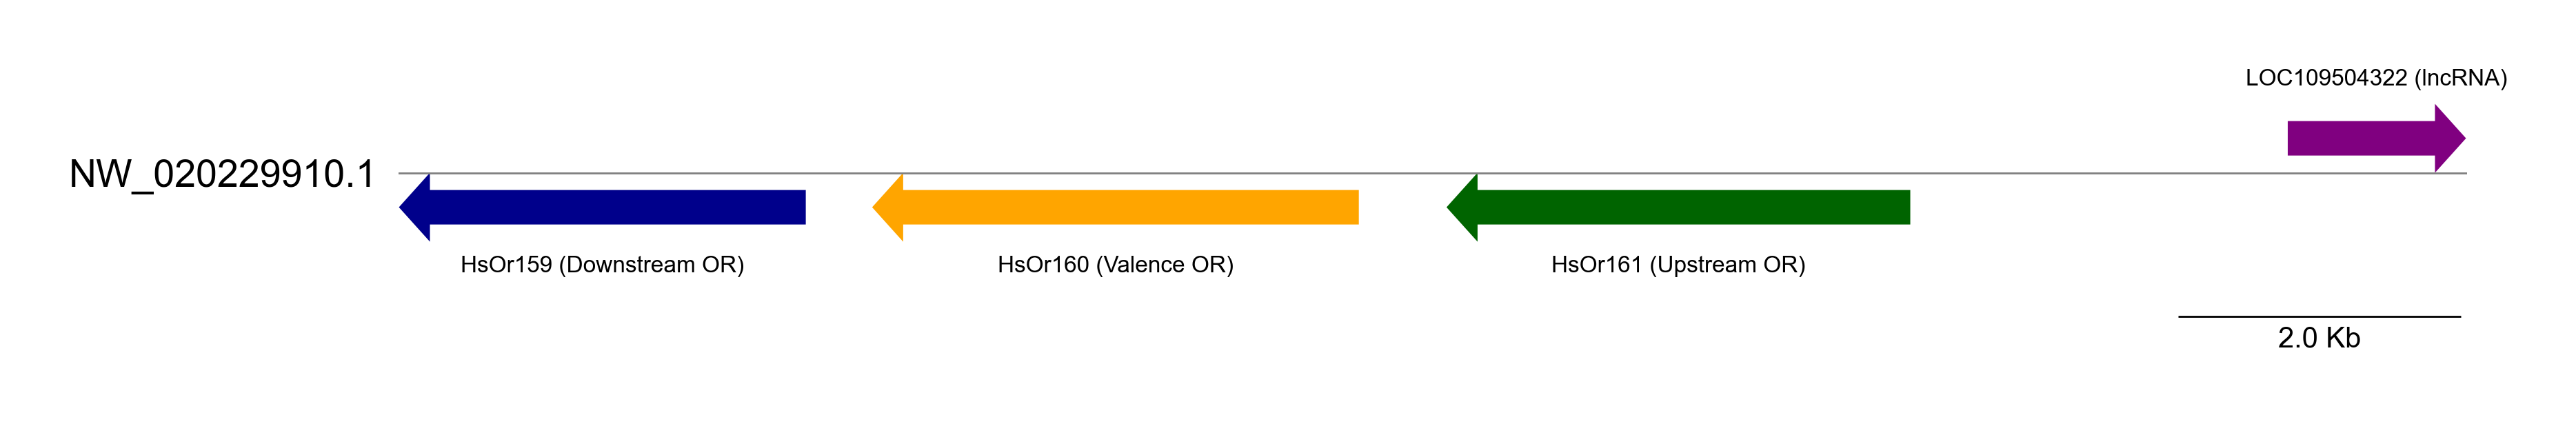

In [84]:
upstream_OR = cells['upstream_OR'].values[0]
downstream_OR = cells['downstream_OR'].values[0]
all_bounds = [tr.get_gene(gene).get_transcript_longest_bounds().get_bounds() for gene in [lncRNA, upstream_OR, valence_OR, downstream_OR]]
chromosome = tr.get_gene(lncRNA).chromosome
start = min([bounds[0] for bounds in all_bounds]) - 5
end = max([bounds[1] for bounds in all_bounds]) + 5
print(f"Chromosome: {chromosome}, Start: {start}, End: {end}")

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 

white_plotting()
gv = GenomeViz(track_align_type="center", theme="light")
gv.set_scale_bar(ymargin=0.5)

fontsize=12 

# Get bounds 
track = gv.add_feature_track(chromosome, segments = (int(start), int(end)))
#track.add_sublabel(size=fontsize)

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_bounds()
    if upstream_OR in gene: 
        color = 'darkgreen'
        label = f'{gene} (Upstream OR)'
    elif downstream_OR in gene:
        color = 'darkblue'
        label = f'{gene} (Downstream OR)'
    elif valence_OR in gene:
        color = 'orange'
        label = f'{gene} (Valence OR)'
    elif lncRNA in gene: 
        color = 'purple'
        label = f'{gene} (lncRNA)'
    else: 
        color = 'grey'
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        text_kws={'color': 'black', 
                  'rotation': 0, 
                  'vpos': vpos, 
                  'hpos': 'center', 
                  'size':fontsize}
    )

fig = gv.plotfig()
plt.show()

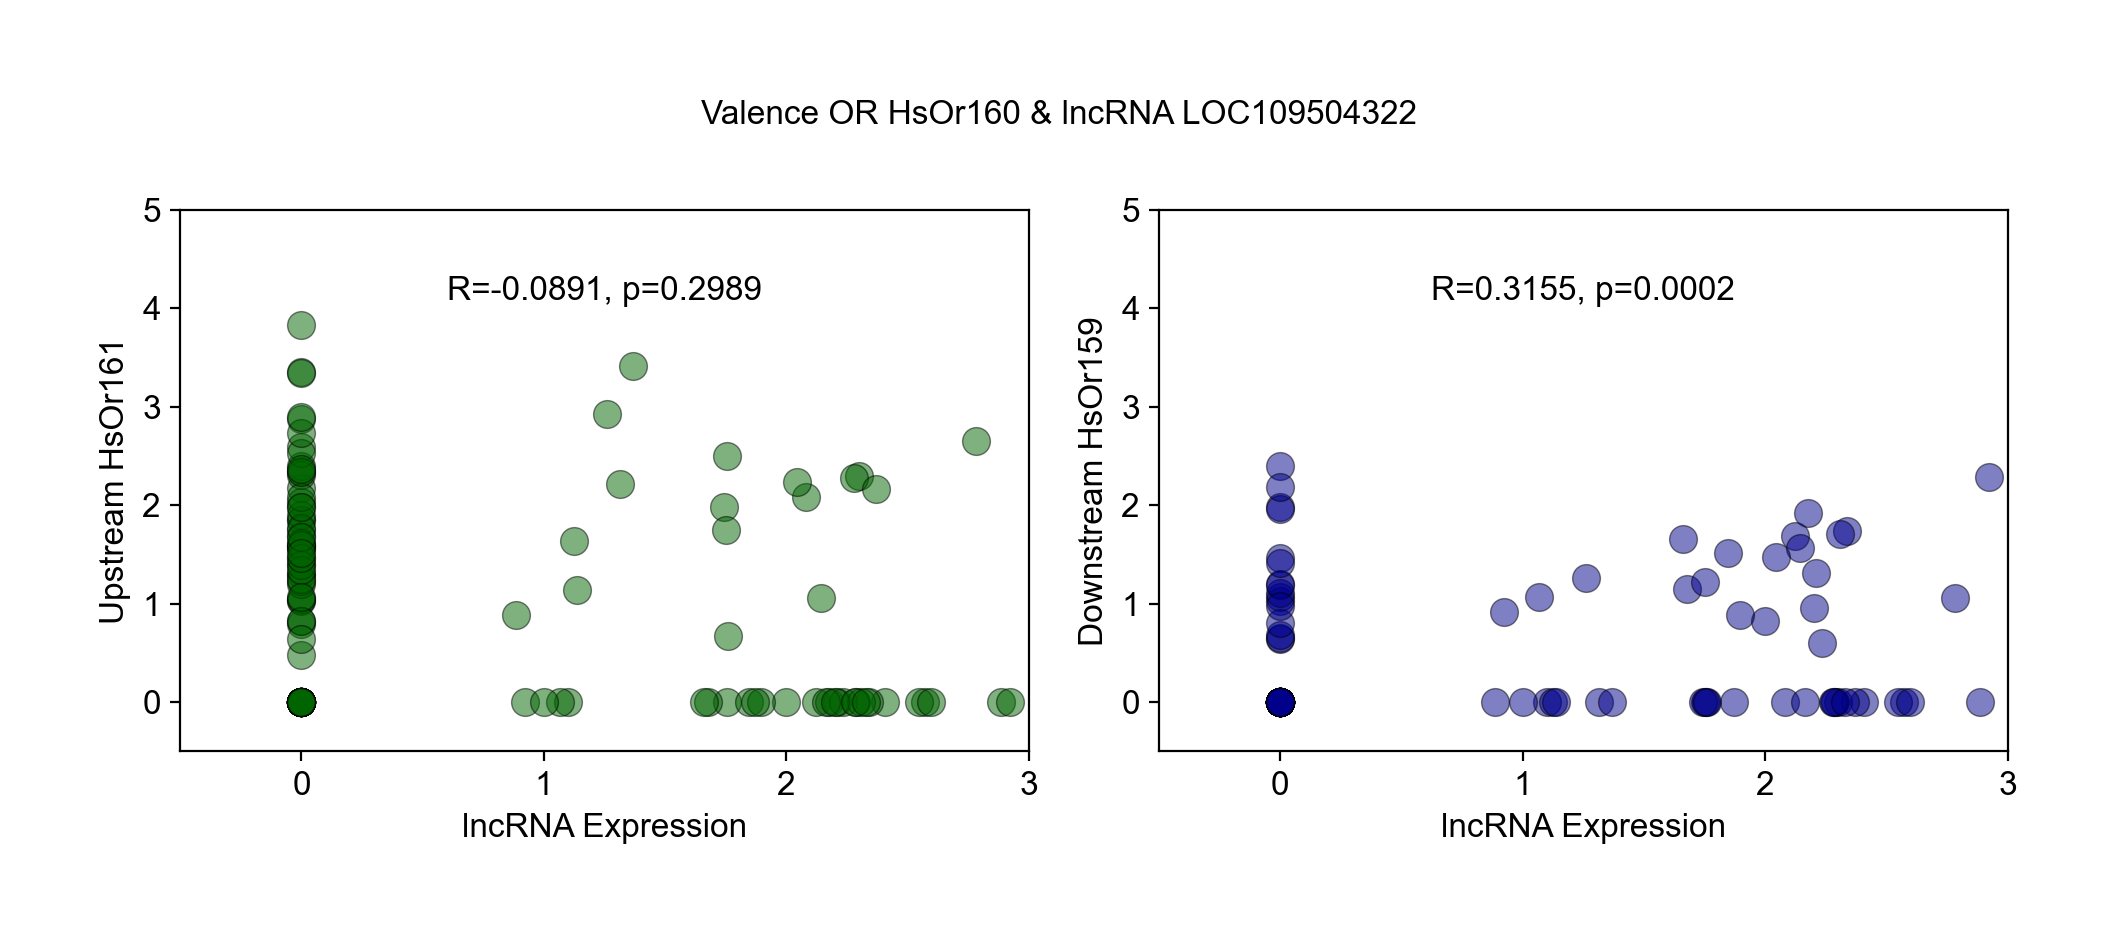

In [85]:
# Plot ustream OR expresion and downstream OR expression vs lncRNA expression bin 
white_plotting()
fontsize=12
f, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
colors = ['darkgreen', 'darkblue']
for i, OR in enumerate(['Upstream', 'Downstream']):
    sns.scatterplot(data=cells, x='lncRNA_expression', y=f'{OR.lower()}_OR_expression', ax=ax[i], color=colors[i], s=100, legend=False, lw=0.5, edgecolor='black', alpha=0.5)
    ax[i].set_xlabel('lncRNA Expression', fontsize=fontsize)
    ax[i].set_ylabel(f'{OR} {cells.iloc[0][OR.lower() + "_OR"]}', fontsize=fontsize)
    r, p = pearsonr(cells['lncRNA_expression'], cells[f'{OR.lower()}_OR_expression'])
    ax[i].text(0.5, 0.85, f'R={r:.4f}, p={p:.4f}', fontsize=fontsize, ha='center', va='center', transform=ax[i].transAxes, color='black')
    ax[i].set_ylim(-0.5, 5)
    ax[i].set_yticks([0, 1, 2, 3, 4, 5])
    ax[i].set_yticklabels(['0', '1', '2', '3', '4', '5'], fontsize=fontsize)
    ax[i].set_xlim(-0.5, 3)
    ax[i].set_xticks([0, 1, 2, 3])
    ax[i].set_xticklabels(['0', '1', '2', '3'], fontsize=fontsize)

plt.suptitle(f"Valence OR {valence_OR} & lncRNA {lncRNA}", fontsize=fontsize)
plt.tight_layout()
plt.show()

## lncRNAs with 3' end close to OR TSS 

In [86]:
min(cell_valence_OR['tss_2_lnc_end']), max(cell_valence_OR['tss_2_lnc_end'])

(821.0, 9895.0)

In [87]:
min(cell_valence_OR['lncRNA_expression']), max(cell_valence_OR['lncRNA_expression'])

(0.0, 5.0341386795043945)

In [88]:
min(cell_valence_OR['upstream_OR_expression']), max(cell_valence_OR['upstream_OR_expression'])

(0.0, 3.8272900581359863)

In [89]:
min(cell_valence_OR['downstream_OR_expression']), max(cell_valence_OR['downstream_OR_expression'])

(0.0, 3.5428831577301025)

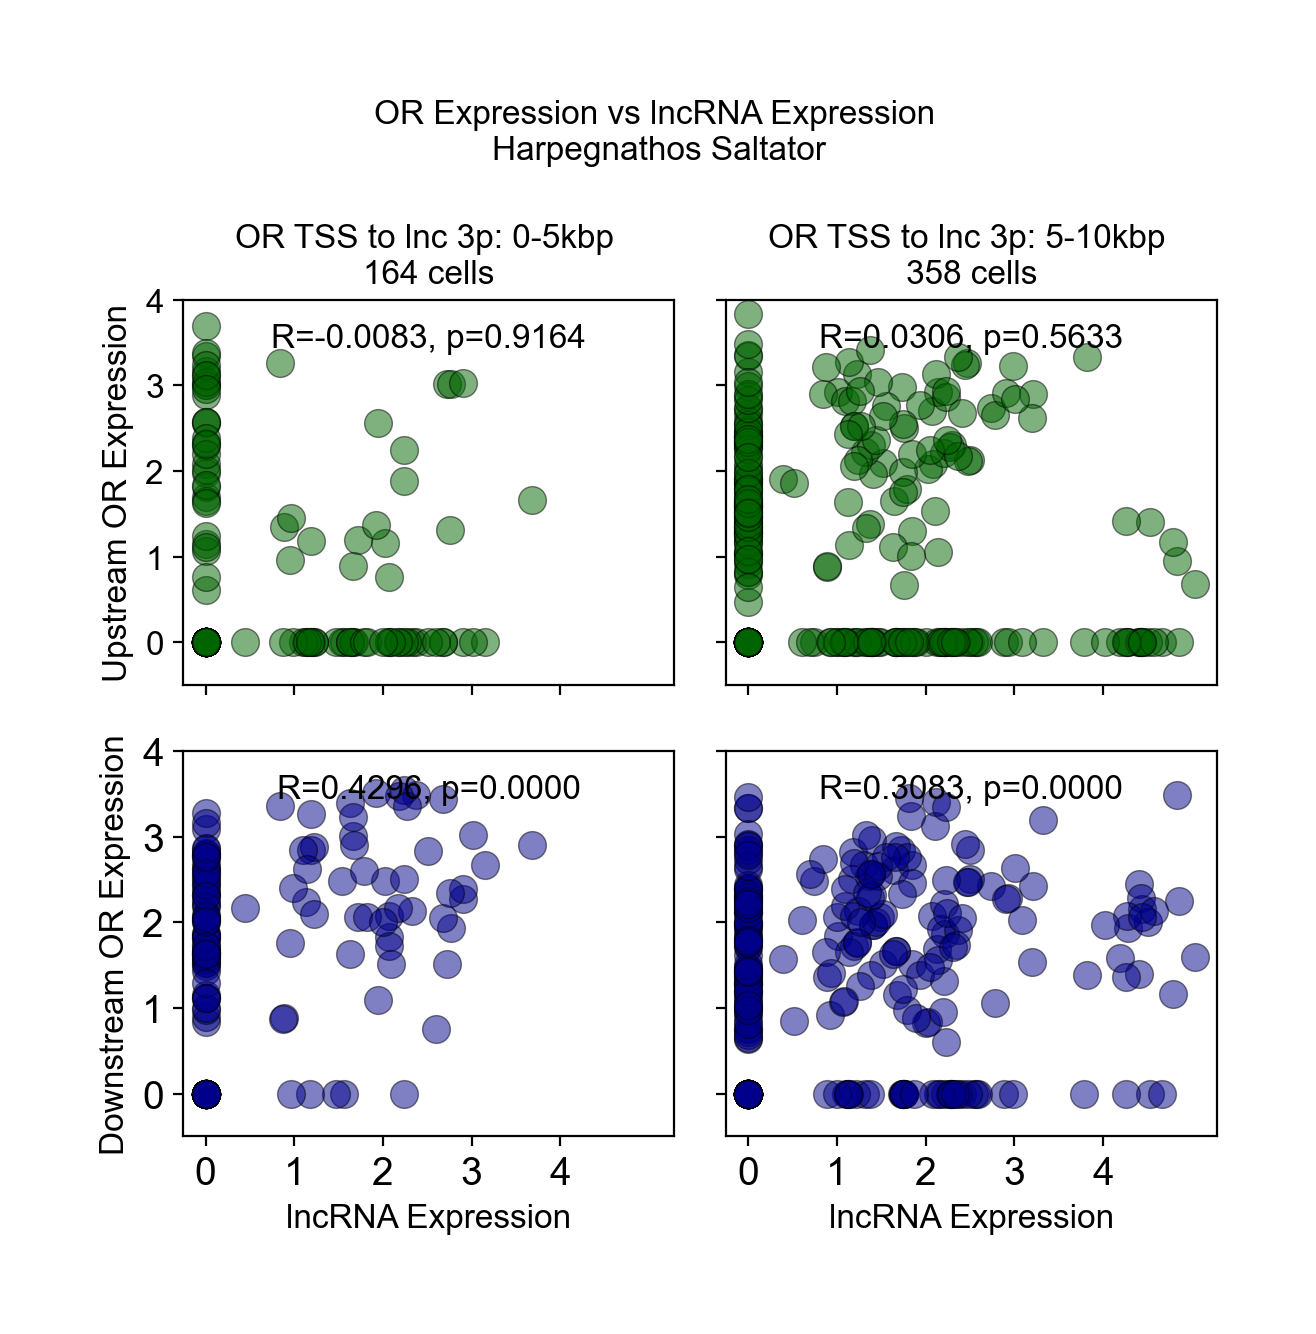

In [90]:
distances = [0, 5000, 10000] 
white_plotting()
fontsize=12
# For each tss_2_lnc_end bin, plot a scatter plot of upstream OR expression vs lncRNA expression
f, ax = plt.subplots(2, len(distances)-1, figsize=(6, 6), sharex=True, sharey=True)
for i in range(len(distances)-1): 
    min_dist = distances[i]
    max_dist = distances[i+1]
    p14_cell_valence_OR_close_bin = cell_valence_OR[(cell_valence_OR['tss_2_lnc_end'] > min_dist) & (cell_valence_OR['tss_2_lnc_end'] < max_dist)]
    
    # Upstream 
    sns.scatterplot(data=p14_cell_valence_OR_close_bin, x='lncRNA_expression', y='upstream_OR_expression', ax=ax[0, i], color='darkgreen', s=100, legend=False, alpha=0.5, lw=0.5, edgecolor='black')
    r, p = pearsonr(p14_cell_valence_OR_close_bin['lncRNA_expression'], p14_cell_valence_OR_close_bin['upstream_OR_expression'])
    ax[0, i].text(0.5, 0.9, f'R={r:.4f}, p={p:.4f}', fontsize=fontsize, ha='center', va='center', transform=ax[0, i].transAxes, color='black')
    ax[0, i].set_ylabel('Upstream OR Expression', fontsize=fontsize)
    ax[0, i].set_title(f'OR TSS to lnc 3p: {int(min_dist/1000)}-{int(max_dist/1000)}kbp \n{p14_cell_valence_OR_close_bin.shape[0]} cells', fontsize=fontsize)
    ax[0, i].set_ylim(-0.5, 4)

    # Downstream 
    sns.scatterplot(data=p14_cell_valence_OR_close_bin, x='lncRNA_expression', y='downstream_OR_expression', ax=ax[1, i], color='darkblue', s=100, legend=False, alpha=0.5, lw=0.5, edgecolor='black')
    r, p = pearsonr(p14_cell_valence_OR_close_bin['lncRNA_expression'], p14_cell_valence_OR_close_bin['downstream_OR_expression'])
    ax[1, i].text(0.5, 0.9, f'R={r:.4f}, p={p:.4f}', fontsize=fontsize, ha='center', va='center', transform=ax[1, i].transAxes, color='black')
    ax[1, i].set_ylabel('Downstream OR Expression', fontsize=fontsize)
    ax[1, i].set_xlabel('lncRNA Expression', fontsize=fontsize)
    ax[0, i].set_yticks([0, 1, 2, 3, 4])
    ax[0, i].set_yticklabels(['0', '1', '2', '3', '4'], fontsize=fontsize)
    # xticks 0 - 6, fontsize
    ax[0, i].set_xticks([0, 1, 2, 3, 4])
    ax[0, i].set_xticklabels(['0', '1', '2', '3', '4'], fontsize=fontsize)

plt.suptitle("OR Expression vs lncRNA Expression \nHarpegnathos Saltator", fontsize=fontsize)

plt.tight_layout()
plt.show()

### Plot Correlations for each unique lncRNA

In [91]:
# Get unique lncRNAs 
lncRNAs = cell_valence_OR['lncRNA'].unique()

# For each lncRNA, get the Pearson correlation of lncRNA expression vs OR expression for upstream and downstream ORs
results = [] 
for lncRNA in lncRNAs: 
    # Get the valence OR with the smallest tss_2_lnc_end
    closest_valence, tss_2_lnc_end = cell_valence_OR.loc[cell_valence_OR['lncRNA'] == lncRNA].sort_values('tss_2_lnc_end').iloc[0][['valence_OR', 'tss_2_lnc_end']]
    cells = cell_valence_OR[(cell_valence_OR['lncRNA'] == lncRNA) & (cell_valence_OR['valence_OR'] == closest_valence)]
    if cells.shape[0] < 3: 
        # Skip if there are fewer than 3 cells, necessary for Pearson correlation
        continue
    r_up, p_up = pearsonr(cells['lncRNA_expression'], cells[f'upstream_OR_expression'])
    r_down, p_down = pearsonr(cells['lncRNA_expression'], cells[f'downstream_OR_expression'])
    r_valence, p_up = pearsonr(cells['lncRNA_expression'], cells['valence_OR_expression'])

    tss_2_lnc_end = cells['tss_2_lnc_end'].values[0]
    tss2tss = cells['tss2tss'].values[0]

    results.append({'lncRNA':lncRNA, 'valence': closest_valence, 'n_cells':cells.shape[0],  'tss_2_lnc_end': tss_2_lnc_end, 'tss2tss': tss2tss, 
                    'r_up': r_up, 'p_up': p_up, 'r_down': r_down, 'p_down': p_down, 'r_valence': r_valence, 'p_valence': p_up})

results = pd.DataFrame(results)
results

lncRNA    valence  n_cells  tss_2_lnc_end  tss2tss      r_up  \
0  LOC109504322    HsOr161       64         3928.0   2668.0 -0.259293   
1  LOC112588178  HsOr257.1       23          821.0    -71.0 -0.108913   
2  LOC112589800    HsOr277       27         3173.0   2447.0 -0.293879   
3  LOC109504323    HsOr164       12         1029.0   -126.0 -0.043732   
4  LOC112589985    HsOr119        3         1595.0  -6852.0       NaN   
5  LOC109503640     HsOr95        3         3071.0    575.0 -0.500000   

       p_up    r_down    p_down  r_valence  p_valence  
0  0.041593  0.301734  0.015390   0.255488   0.041593  
1  0.629092  0.251926  0.246195   0.106358   0.629092  
2  0.086264  0.565880  0.002095   0.336356   0.086264  
3  0.010751  0.908537  0.000043   0.703096   0.010751  
4  0.129304  0.877782  0.318045   0.979444   0.129304  
5  0.511580  0.643161  0.555245   0.694129   0.511580

In [92]:
cell_valence_OR[(cell_valence_OR['lncRNA'] == 'LOC112589985') & (cell_valence_OR['valence_OR'] == 'HsOr119')]

cell_index valence_OR  tandem_array or_strand        lncRNA  \
226  GTGAGCCGTTTGTTGG-1-1    HsOr119             4         +  LOC112589985   
425  GATCATGCATCTATCT-1-2    HsOr119             4         +  LOC112589985   
521  TTTCAGTGTTTACCTT-1-2    HsOr119             4         +  LOC112589985   

     tss_2_lnc_end  tss2tss lnc_strand  lncRNA_expression  \
226         1595.0  -6852.0          -           1.630568   
425         1595.0  -6852.0          -           0.000000   
521         1595.0  -6852.0          -           0.000000   

     valence_OR_expression upstream_OR downstream_OR upstream_OR_strand  \
226               3.522063     HsOr118       HsOr120                  +   
425               2.493105     HsOr118       HsOr120                  +   
521               2.215384     HsOr118       HsOr120                  +   

    downstream_OR_strand  upstream_OR_expression  downstream_OR_expression  
226                    +                     0.0                  3.392743  
425                    +                     0.0                  0.000000  
521                    +                     0.0                  1.625797

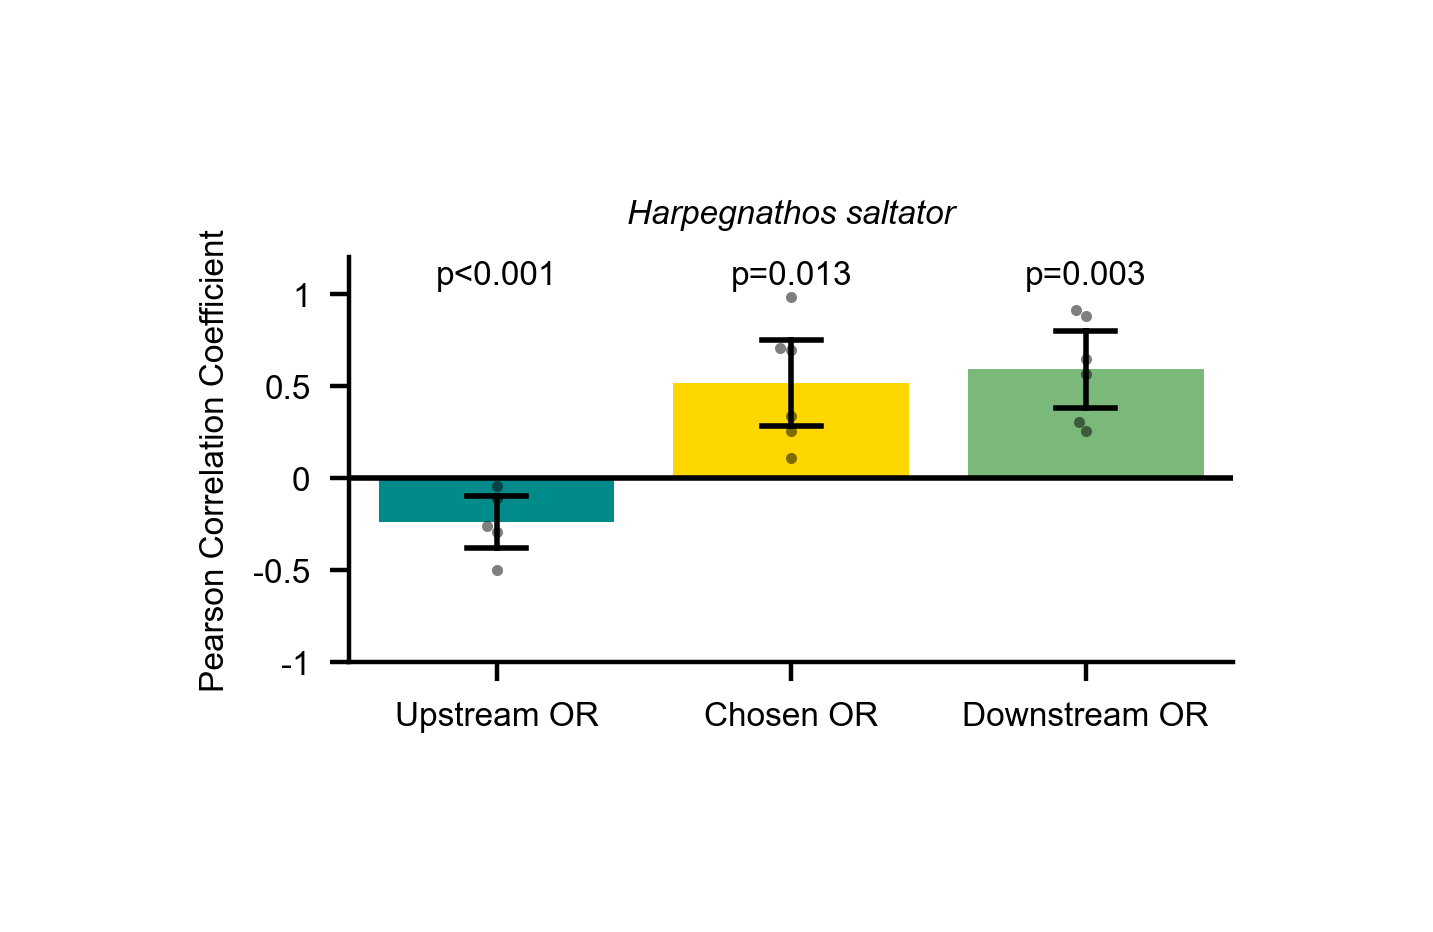

In [93]:
# Plot bar plot of unique lncRNAs with closest valence OR, r_up, r_valence, r_down
max_distance = 5_000 
results_subset = results[(results['tss_2_lnc_end'] < max_distance) & (results['tss_2_lnc_end'] > 0)]
white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
f, ax = plt.subplots(1, 1, figsize=(3, 1.75), dpi=200)


sns.barplot(data=results_subset, x=0, y='r_up', ax=ax, color='darkcyan', alpha=1, label='Upstream', saturation=1, errcolor='black', capsize=0.2, errwidth=1)
sns.barplot(data=results_subset, x=1, y='r_valence', ax=ax, color='gold', alpha=1, label='Valence', saturation=1, errcolor='black', capsize=0.2, errwidth=1)
sns.barplot(data=results_subset, x=2, y='r_down', ax=ax, color='forestgreen', alpha=0.6, label='Downstream', saturation=1, errcolor='black', capsize=0.2, errwidth=1)

sns.swarmplot(data=results_subset, x=0, y='r_up', ax=ax, color='black', size=2, alpha=0.5)
sns.swarmplot(data=results_subset, x=1, y='r_valence', ax=ax, color='black', size=2, alpha=0.5)
sns.swarmplot(data=results_subset, x=2, y='r_down', ax=ax, color='black', size=2, alpha=0.5)

ax.set_xticks([0, 1, 2], ['Upstream OR', 'Chosen OR', 'Downstream OR'], fontsize=6)
ax.set_ylabel('Pearson Correlation Coefficient', fontsize=6)
ax.set_title('Harpegnathos saltator', fontsize=6, style='italic')
plt.legend([],[], frameon=False)
ax.set_ylim(-1, 1.2)
ax.set_yticks([-1, -0.5, 0, 0.5, 1], labels=['-1', '-0.5', '0', '0.5', '1'], fontsize=6)
# line at y=0
plt.axhline(0, color='black', lw=1)

# remove spines 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Add stats (different from 0) 
from scipy.stats import ttest_1samp
for i, or_ in enumerate(['up', 'valence', 'down']):
    r = results_subset[f'r_{or_}']
    t, p = ttest_1samp(r, 0)
    p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
    plt.text(i, 1.1, p_value_str, ha='center', va='center', transform=ax.transData, fontsize=6, color='black')

plt.tight_layout()
plt.savefig(f"../figures/Hsalt-lnc-inhibits-correlations.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()